# RAG 청킹 전략 비교 실험

이커머스 판매자 어드민 가이드 문서에 대한 청킹 전략별 검색 품질을 비교한다.

| 순서 | 전략 | 설명 |
|------|------|------|
| 1 | 페이지 단위 | 페이지 전체를 하나의 청크로 (baseline) |
| 2 | RecursiveCharacterTextSplitter | 고정 길이 + 오버랩 |
| 3 | 헤딩 기반 | H2/H3 경계로 분할 |
| 4 | Semantic Chunking | 임베딩 유사도 변곡점으로 분할 |

## 0. Setup

### 1) 라이브러리 설치

In [123]:
%pip install -q openai scikit-learn matplotlib python-dotenv langchain-text-splitters langchain-experimental langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [125]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt # 차트 그리기 (EDA 막대그래프)
import numpy as np # 숫자 배열 처리 (scikit-learn 설치 시 자동 설치)
from dotenv import load_dotenv # 환경변수 로드
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity # 코사인 유사도 계산 (두 벡터가 얼마나 비슷한지 0~1로 점수 매김)

### 2) .env에서 API 키 로드 (VSCode 로컬)

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    from google.colab import userdata  # type: ignore[import-not-found]
    api_key = userdata.get("OPENAI_API_KEY")
else:
    load_dotenv(Path(__file__).resolve().parent.parent / "backend" / ".env" if "__file__" in dir() else "../backend/.env")
    api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=api_key)

### 3) 임베딩 관련 기본값 정의

In [36]:
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_DIM = 1536

### 4) 한글 폰트 설정

matplotlib의 기본 폰트(DejaVu Sans)에 한글 글리프가 없어서 한글을 포함한 폰트를 명시적으로 지정해야 한다.
- macOS: `AppleGothic`
- Colab(Linux): `NanumGothic`

In [ ]:
plt.rcParams["font.family"] = "NanumGothic" if IS_COLAB else "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

## 1. 데이터 로드

### 1) JSON 파일 로드

In [ ]:
_FAQ_RAW = """
[
  {
    "url": "https://help.pro.sixshop.com/shoppingmall-start",
    "title": "쇼핑몰 빠른 시작 가이드",
    "content": "쇼핑몰 개설 준비와 운영에 도움이 되는 권장 설정까지, 이번 가이드에서 한번에 끝내 보세요!\nTIP 첨부된 이미지가 잘 보이지 않는다면?🫥 → 클릭하면 이미지가 확대돼요!\n### 1. 기본 설정\n#### 기본 정보 입력\n식스샵 프로 계정에 로그인 후, 먼저 [설정 > 스토어 정보]의 스토어 이름을 점검해 주세요.\n•\n이 정보는 고객에게 실제 발신되는 이메일/알림톡/문자 등에 포함되니 정확한 브랜드명을 입력해 주세요.\n•\nTIP! 스토어 아이디는 생성 후 변경이 불가하지만, 중요도가 높은 정보는 아니에요. 운영자의 관리용 도메인(ID.sixshop.site)에만 적용되기 때문에 커스텀 도메인 연결 후에는 외부 노출되지 않아요.\n\n#### 상품 등록/노출\n쇼핑몰의 필수 요소인 상품을 등록하고, 상점에 노출하는 과정입니다.\n 상품 등록하기\n[상품 관리 > 상품]에서 [상품 추가하기] 클릭 후, 판매할 상품을 등록합니다. (①)\nTIP! 아주 많은 상품을 일괄 등록하시려면, 엑셀 파일로 업로드하실 수도 있어요.(②)\n\n필수 입력 정보인 이름, 가격, 배송 정보뿐만 아니라, 상품 카테고리까지 설정해 주셔야 상품이 정상 노출되니 유의해 주세요!\n\n 상품 노출하기\n① [웹사이트 > 디자인]에서 테마를 추가한 후, [디자인 편집하기]를 클릭하여 에디터로 이동해 주세요.\n② 에디터 상단의 [섹션] 클릭 후, 본문 영역 옆 [+]를 클릭하여 ‘상품’ 관련된 섹션을 추가해 주세요.\nTIP! 빠른 PG(결제 서비스) 심사를 위해, 최소 상품인 1개만 먼저 노출해 주셔도 돼요.\n③ 오른쪽 상품 패널의 [데이터] 탭에서 원하는 상품만 노출 후 [사이트 게시]하면 상품이 사이트에 공개돼요.\n\n자세한 방법은 [상품 노출하기](/77226391-0632-41a1-850f-d195b2814d0c)에서 살펴볼 수 있습니다.\n#### 쇼핑몰 플랜 결제\n상품 등록을 마쳤다면, 왼쪽 하단 [플랜 업그레이드] 버튼을 클릭하여 플랜 결제 후에 다음 과정을 진행할 수 있어요.\n•\n기업 홈페이지나 개인 포트폴리오 사이트가 아닌, 상품 판매를 위한 ‘쇼핑몰’이라면 꼭 ‘쇼핑몰’ 플랜을 결제해 주셔야 해요!\n•\nTIP! 플랜 결제 금액은 사용 일수를 일할 차감 후 언제든 환불 가능하니 가볍게 이용해 보세요!\n\n#### PG 신청\n상품을 구매하려는 고객이 ‘결제’할 수 있도록 PG(결제 서비스) 연동이 필요해요. (비용 무료)\n 법적 필수 정보/약관 등록\n[설정 > 약관 및 필수 정보]에서 PG 심사 항목인 법적 필수 정보와 약관을 빠르게 등록합니다.\n이용 약관은, 예시 약관이 준비되어 있어 상호명 항목만 채워 주시면 돼요.\n\n PG 신청\n[설정 > 결제 설정]에서 [PG 연동 신청하기] 버튼으로 간편하게 신청할 수 있어요. 신청만 하셔도 6분 만에 일시불 카드 결제가 오픈됩니다! (미리 오픈)\n\n자세한 방법과 심사 절차는 [토스페이먼츠](/1994b16e-2bf1-8085-a969-cd41d24f10a1)(클릭)에서 살펴볼 수 있습니다.\nTIP! 디자인은 심사 요소가 아니기 때문에, 우선 PG부터 신청하고 디자인을 해 주시는 편이 좋아요.\n### 2. 판매 준비\n#### 디자인 편집\n식스샵 프로가 제공하는 다양한 섹션들로 감각적인 쇼핑몰을 디자인해 보세요!\n•\n관리 홈 왼쪽 네비게이션의 [디자인 편집]을 클릭하면 빠르게 에디터로 이동합니다.\n•\nTIP! 디자인에 어려움이 있다면, 아래 링크를 클릭하여 식스샵 프로 공식 파트너들에게 원하는 예산으로 제작을 의뢰해 보세요!\n[식스샵 | 파트너\n더 쉽게, 더 멋지게. 이제는 식스샵 파트너에게 맡기세요!\n\nhttps://www.sixshop.com/official-partner\n](https://www.sixshop.com/official-partner)\n\n자세한 디자인 작업 방법은 [웹사이트 디자인](/e7b780d5-b655-4f4e-8bc9-57dcfcebfab3)(클릭)에서 살펴볼 수 있습니다.\n#### 도메인 연결\n구매해 둔 도메인이 있다면, 식스샵 프로 사이트와 연결할 수 있어요.\n•\n[설정 > 도메인]에서 [도메인 연결하기] 버튼을 클릭하여 도메인 입력 후, 4개의 네임서버(호스트 이름)를 확인할 수 있어요. 이 네임서버를 도메인 구매처에 입력하면 약 24시간 이내 연결됩니다.\n\n자세한 방법은 [도메인 연결하기](/a6a590cd-41c1-4c85-9bed-c5b93cfcd8dd)(클릭)에서 살펴볼 수 있습니다.\n#### 간편결제 연동\n구매자의 귀찮음을 줄이고 빠른 결제를 유도하는 방법, 바로 간편결제 수단이에요. 주요 간편결제인 네이버페이/카카오페이를 무료 연동해 보세요.\n 네이버페이\n네이버페이는 주문형/결제형 2가지 방식으로 제공되고, 네이버페이센터에서 각각 계정 가입 후 심사를 받을 수 있어요. (동시 연동 가능)\n\n자세한 신청 방법은 [네이버페이](/b8734853-2aaf-41fa-8ffe-43d40bee9b56)(클릭)에서 살펴볼 수 있습니다.\nTIP! 주문형/결제형을 모두 이용하시려면 주문형 → 결제형 순으로 진행해 주셔야 정산 주기 협의에 유리해요.\n 카카오페이\n카카오페이는 별도 계약이 아닌, 토스페이먼츠 PG 계약 내에 함께 신청하는 방식이에요.\n\n자세한 신청 방법은 토스페이먼츠 고객센터로 문의해 주세요!\n전화 문의: 1544-7772\n채팅 상담: [https://www.tosspayments.com](https://www.tosspayments.com/) > 채팅 아이콘 클릭\n### 3. 추가 권장 설정\n#### 운영 알림 설정\n다양한 상황에서 고객님과 운영자님 모두 알림을 받아 볼 수 있어요.\n•\n고객님은 [배송 시작], [쿠폰 지급] 등 운영자님께서 설정해 둔 중요 시점에 안내를 받을 수 있어요.\n•\n운영자님은 관리 홈에 계속 머무르지 않아도 여러 운영 상황에서 편리하게 알림을 받을 수 있어요.\n 이메일 알림\n[설정 > 이메일 발신]에서 원하는 발신 시점을 사용 설정하면 메일을 받아 볼 수 있어요. (무료)\n\n자세한 방법은 [이메일](/dc3f137a-c609-42eb-9784-8b022f41b3c0)가이드에서 살펴볼 수 있습니다.\n 알림톡/문자 알림\n[설정 > 카카오 알림톡/문자 발신]에서 카카오톡 채널이나 발신번호를 등록하고, 원하는 발신 시점을 사용 설정하면 알림톡/문자를 받아 볼 수 있어요. (건당 유료)\n\n자세한 방법은 [카카오 알림톡/문자](/9adebf23-b4a2-4f2c-869c-92447c5e674a)가이드에서 살펴볼 수 있습니다.\n#### 소셜 로그인\n카카오/네이버 소셜 계정을 활용하여 3초 만에 자사몰 회원 가입을 유도할 수 있어요.\n•\n[설정 > 회원 가입 설정]의 소셜 로그인 설정에서 카카오/네이버 로그인을 5분 이내 간편하게 연동할 수 있어요.\n\n자세한 방법은 [소셜 로그인](/e3dbfd18-7d06-4b0e-bf98-df0c7ad0077e)(클릭)에서 살펴볼 수 있습니다.\n#### SEO 설정\n쇼핑몰이 네이버/구글 검색 엔진에 더욱 원활히 노출될 수 있도록, 검색 엔진 최적화 작업을 완료해 보세요.\n 기본 SEO 설정\n[설정 > 외부 서비스]에서 네이버 웹마스터/구글 서치 콘솔 항목에 HTML 태그 값을 입력해 두면 약 2-4주 이내 사이트가 검색 엔진에 노출됩니다.\n•\n사이트 검색 시 노출되는 제목/설명은 [설정 > 웹사이트 정보]에서 입력할 수 있어요.\n\n자세한 방법은 [검색 노출(SEO) 기능 연동](/d8f8f113-46b3-4f7d-8776-c42e3b12f8fc)(클릭)에서 살펴볼 수 있습니다.\nTIP! 해당 서비스들은 사이트 노출에 도움을 주는 기능이며, 상단 노출을 보장하지는 않습니다.\n 페이지별 SEO 설정(선택 사항)\n디자인 에디터에서 페이지마다 보여 줄 제목/설명 텍스트를 커스텀하여 검색 노출 완성도를 높일 수 있어요.\n\n자세한 방법은 [페이지별 SEO 설정하기](/1f84b16e-2bf1-808d-adc3-f5676facf223) (클릭)에서 살펴볼 수 있습니다.\n#### 마케팅 세팅\n쿠폰, 고객 세그먼트, 마케팅 메시지(친구톡) 등 식스샵 프로의 강력한 마케팅을 활용해 보세요!\n 쿠폰 활용하기\n[마케팅 > 쿠폰]에서 쿠폰을 추가하고 고객에게 지급해 보세요. ‘회원 가입 시 자동 지급’ 기능을 사용한 가입 축하 쿠폰이 가장 일반적이에요.\n\n특별한 쿠폰을 원한다면 [특정 상품에만 첫 구매 쿠폰 적용하기](/2384b16e-2bf1-805e-8a42-d73e11e5e097)(클릭)를 활용하여 첫 구매 100원 딜처럼 응용할 수도 있어요\n 마케팅 템플릿 활용하기\n[마케팅 > 템플릿]에서 클릭 몇 번만으로 자사몰 마케팅을 간편하게 따라 할 수 있어요.\n마케팅 템플릿은 식스샵 프로가 준비한 주요 마케팅 예시예요. 원하는 값(설정일, 할인 금액 등)만 입력해서 세그먼트/마케팅 메시지를 한번에 이용해 보세요.\n\n추가 설정은 [마케팅 메시지](/4c960f84-d21d-4207-b091-22fe64462f8b) / [고객 세그먼트](/32f83194-4262-4042-b4c1-596693b07a5b) (클릭)에서 살펴볼 수 있습니다.\n#### 마켓 통합 관리\n식스샵 프로는 스마트스토어, 쿠팡, 무신사, 지그재그 등 다양한 마켓과의 상품/주문 연동을 지원해요.\n•\n특히 운영자님들의 선호도가 높은 마켓인 ‘스마트스토어’의 경우, 스마트스토어식스샵 프로 양방향 상품 연동을 지원하니 편리하게 판매 채널을 확장해 보세요.\n\n자세한 이용 방법은 [마켓 통합 관리](/3a7dbf6e-9a31-4aaa-ac87-f4a554ad0ab0)(클릭)에서 살펴볼 수 있습니다.",
    "breadcrumb": "식스샵 프로 가이드 > 쇼핑몰 빠른 시작 가이드",
    "content_length": 4680
  },
  {
    "url": "https://help.pro.sixshop.com/customers/grade",
    "title": "고객 등급 관리",
    "content": "#### 등급 추가하기\n[식스샵 프로 > 고객 관리 > 등급]의 우측 상단 등급 추가하기로 등급을 추가할 수 있습니다.\n\n•\n기본 정보\n◦\n등급 이름\n▪\n등급의 이름입니다. 최대 100자 설정할 수 있습니다.\n◦\n할인 혜택\n▪\n할인 혜택 기능을 이용하면 해당 등급의 고객은 설정된 금액에 따라 할인을 받습니다.\n•\n정액(원): 매 주문마다 정해진 할인 금액이 적용됩니다.\n•\n정률(%): 매 주문마다 정해진 할인율이 적용됩니다.\n•\n추가 정보\n◦\n추가 적립금\n▪\n추가 적립금 기능을 이용하면 해당 등급의 고객은 설정된 비율에 따라 추가 적립을 받습니다.\n▪\n[설정 > 적립금 설정]에 구매 적립금을 설정한 상태에서만 추가 적립금을 설정할 수 있습니다.\n등급 할인과 추가 적립금 혜택은 해당 등급의 고객이 확인할 수 있는 정보인 점 유의해 주세요.\n등급이 추가되었다면 우측 ••• 아이콘으로 정보를 수정/삭제하거나 해당 등급에 연결된 고객 정보를 확인할 수 있습니다.\n각각의 등급 우측 ••• 아이콘으로 작업하는 항목\n•\n수정하기 : 등급 추가 시 설정한 정보를 수정할 수 있습니다.\n•\n연결된 고객보기 : 해당 등급에 연결된 고객의 정보를 확인할 수 있습니다.\n\n•\n삭제하기 : 등급을 삭제할 수 있습니다.\n◦\n해당 등급에 연결된 고객이 없는 상태에서만 삭제가 가능합니다. 연결된 고객이 있다면 모두 다른 등급으로 변경한 후 진행해 주세요.\n#### 고객 등급 자동 조정하기\n승급 조건을 만족한 고객들의 등급을 편리하게 자동 조정할 수 있습니다.\n[\n등급 자동 조정 살펴보기](/9966d986-6f4c-4065-8db1-3f30e6c2d62c)\n\n#### 고객 등급 수동 조정하기\n[식스샵 프로 > 고객 관리 > 고객]에서 대상 고객을 ✓(체크박스) 선택 후, 상단의 등급 변경 버튼을 클릭하여 등급을 조정할 수 있습니다.\n•\n우측 상단 필터 아이콘을 활용하면 특정 등급에 연결된 고객들만 확인할 수 있습니다.\n\nQ1. 고객은 자신의 등급과 혜택을 어디서 볼 수 있나요?\n마이페이지와 상품 목록/상품 상세 페이지에서 확인할 수 있습니다.\n1.\n마이페이지\n고객은 [마이페이지 > 회원정보 수정] 페이지에서 등급과 등급 혜택(할인, 추가 적립금)을 확인할 수 있습니다.\n2.\n상품 목록/상품 상세 페이지\n등급 할인 혜택이 적용된 상품 가격이 자동 노출됩니다. 또한 상품 상세 페이지에서는 물음표 아이콘에 마우스를 올려 고객의 등급 할인 혜택을 상세히 확인할 수 있습니다.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 고객 > 고객 등급 관리",
    "content_length": 1214
  },
  {
    "url": "https://help.pro.sixshop.com/products/add-product",
    "title": "상품 추가하기",
    "content": "설정 목차를 활용하면 원하는 항목으로 빠르게 이동하며 등록할 정보만 선택해 상품 등록을 더욱 효율적으로 진행할 수 있습니다.\n#### 상품 추가 패널 구성 살펴보기\n\n### 기본 설정\n#### 서브 패널 설정하기\n 웹사이트 판매 상태\n•\n판매 중으로 선택하면 웹사이트에 상품을 공개할 수 있어요.\n•\n일시 품절하기에 체크하면 웹사이트에 상품은 공개되고, 품절 상품으로 노출됩니다.\n 검색 노출\n웹사이트에서 상품을 검색했을 때, 검색 결과에 노출되지 않도록 설정할 수 있어요.\n\n노출 안 함 설정 시 참고 사항\n•\n‘노출 안 함’으로 설정된 상품이라도 웹사이트 에디터에서 섹션에 설정하거나, 해당 카테고리를 메뉴에 연결하거나, 상품 상세 페이지 URL로 직접 접근하면 노출됩니다.\n•\n‘노출 안 함’으로 설정하면 메타 카탈로그와 네이버 쇼핑 EP에 해당 상품 정보가 전송되지 않습니다.\n 상품 ID\n상품ID는 상품별로 자동 생성되는 고유 값으로, 상품 정보를 변경해도 변하지 않아 데이터 추적 및 관리에 활용할 수 있어요.\n 상품 관리 코드\n상품 관리 용이성을 위해 상품마다 부여하는 코드입니다.\n 하위 주소\n상품 고유 URL의 일부로, 고객이 쉽게 인식할 수 있도록 설정할 수 있어요.\n•\n상품 ID로 설정: 상품을 추가하면 생성되는 상품 ID로 상품 하위 주소를 설정할 수 있어요.\n•\n직접 입력: 영어 소문자, 숫자, -, \\_를 사용하여 직접 입력할 수 있어요. (최대 50자, 공백 제외)\n#### 필수 입력 정보\n상품을 추가하려면 반드시 입력해야 하는 항목입니다.\n\n기본 정보 - 상품 이름\n웹사이트에 노출되는 상품 이름을 100자 이내로 입력할 수 있어요.\n\n가격 정보 - 정가\n정가에 판매 가격을 입력할 수 있어요. 할인을 적용하면, 할인이 적용된 가격(판매가)으로 상품이 판매됩니다.\n\n배송 정보\n\n배송 설정은 상품 등록 후 수정할 수 없습니다.\n배송 방식이 설정된 상품은 배송 설정 안 함으로 변경할 수 없으니 상품 등록 시 유의해 주세요.\n•\n배송 설정함\n배송 상품인 경우 선택해 주세요. 배송 방식을 선택하고 배송비 부과 방식을 설정할 수 있어요.\n합산: 주문 시 동일 배송 방식을 가진 모든 상품에 배송비가 1회 부과됩니다.\n별산: 주문 시 상품의 수량만큼 배송비가 반복 부과됩니다.\n•\n배송 설정 안 함: 배송을 하지 않는 서비스 상품인 경우 선택해 주세요.\n\n배송 설정 안 함 선택 시 참고 사항\n•\n비배송 상품은 네이버페이 주문형 정책에 따라 네이버페이로 구매할 수 없습니다.\n•\n비배송 상품은 상세 페이지에서 단독 구매만 가능합니다. ( 차후 개선 예정)\n•\n비배송 상품은 연동된 채널에서 가져오거나 식스샵 프로에서 연동된 채널로 내보내기 할 수 없습니다. ( 차후 개선 예정)\n•\n상품 일괄 업로드는 배송 상품만 지원됩니다. ( 차후 개선 예정)\n#### 기본 정보(요약 설명, 이미지 추가)\n\n요약 설명\n상품 목록에서 상품 이름 아래 요약 설명이 노출됩니다.\n구매자가 상품에 관심을 갖고 상세 페이지로 유입될 수 있도록, 상품의 특징이나 혜택이 잘 드러나는 문구를 간단히 작성해 주세요.\n\n이미지 추가\n\n파일명에 괄호 - (,)가 포함되면 이미지가 정상 노출되지 않을 수 있으니 유의해 주세요.\n•\n최대 30개의 이미지를 등록할 수 있어요.\n•\nPNG, JPG(JPEG), WEBP, GIF 파일 형식을 지원하며, 10MB 이하의 이미지를 업로드해 주세요.\n•\n권장 이미지 크기는 가로 2,000px, 세로 3,000px 이하입니다.\n#### 카테고리\n상품 추가 시 필수 입력 항목은 아니지만, 카테고리를 설정해야 웹사이트에 상품이 노출됩니다.\n상품을 웹사이트에 게시하려면 반드시 카테고리를 지정해 주세요.\n더 자세한 설정 방법은 [카테고리 관리하기](/9fcf19db-6f0b-4882-aa59-a2a9d3cc90cb) 에서 확인해 주세요.\n#### 상세 설명\n상품 상세에 노출되는 상품의 설명을 이미지나 텍스트로 등록해 주세요.\n배송 및 교환 반품 정책, 이벤트, 공지사항 등 상품 판매 시 반복 작성해야 하는 정보를 템플릿으로 추가하여 상품 등록/수정 시 상품 설명의 머리글과 바닥글에 간편하게 연동할 수 있어요.\n더 자세한 설정 방법은 [공통 정보 관리 활용하기](/b36a95a8-c0c3-4c56-888e-3eab1b170bcd) 에서 확인해 주세요.\n#### 재고\n재고 연결하기를 눌러서 생성된 재고를 연결하거나, 새로운 재고를 생성할 수 있어요.\n더 자세한 설정 방법은 [재고 관리하기](/3a22ef3e-1c66-461f-92ee-4ccf841bc2dc)에서 확인해 주세요.\n### 옵션 설정\n\n설정 목차에서 선택한 설정을 사용 해제하면 입력한 내용이 초기화되니 주의해 주세요.\n더 자세한 설정 방법은 [옵션 관리하기](/9e5b2ea2-5d61-40f4-bc34-04249575c999)에서 확인해 주세요.\n#### 옵션\n한 가지 상품에 다양한 옵션을 추가해 품목별 가격과 재고를 관리할 수 있어요.\n\n#### 추가 옵션\n상품 추가/수정 시, 선택형/작성형 2개 유형으로 추가 옵션을 설정할 수 있어요.\n최대 10개까지 설정할 수 있으며(①), 노출 순서를 변경하거나 삭제할 수 있어요.(②)\n\n#### 상품 전시 관리\n상품의 노출 방식을 설정할 수 있어요.\n•\n상품 단위\n웹사이트의 상품 목록에서 상품을 클릭하여 상품 상세 페이지에서 옵션을 선택할 수 있는 기본적인 상품 전시 방식이에요.\n•\n옵션 단위\n웹사이트 상품 목록에서 상품의 옵션을 기준으로 전시됩니다. 옵션에 등록한 이미지는, 옵션 단위로 전시될 때 대표 이미지로 사용됩니다.\n\n더 자세한 설정 방법은 [상품 전시 방식 설정하기](/ef647067-2b18-4440-a648-5c65ba31f241) 에서 확인해 주세요.\n### 고급 설정\n#### 보조 설명\n구매자의 상품 이해를 돕기 위해 상품의 상세 설명 외에 추가로 상품의 정보를 입력하여 상품의 구매를 촉진할 수 있어요.\n•\n보조 설명은 최대 5개까지 입력할 수 있고, 순서를 변경할 수 있어요.\n•\n보조 설명 제목은 최대 50자, 설명은 최대 10만 자(HTML 기준)까지 입력할 수 있어요.\n\n#### 구매 수량 제한\n•\n1회 구매 시 수량 제한\n◦\n최소 구매 수량: 2개~100개까지 설정할 수 있어요.\n◦\n최대 구매 수량: 1개~100개까지 설정할 수 있어요.\n◦\n최소/최대 구매 수량: 최소 수량은 ‘최대 구매 수량’ 이하인 범위 내에서 2개~100개까지, 최대 수량은 1개~100개까지 설정할 수 있어요.\n•\n제한 기준\n◦\n상품 단위: 옵션이 없는 단일 상품일 경우, 상품 단위만 선택할 수 있어요. 옵션이 존재하는 상품이라면, 상품의 옵션의 총 개수를 기준으로 최소/최대 구매 수량을 설정할 수 있어요.\n◦\n세부 품목 단위: 옵션이 존재하는 상품이라면, 세부 품목별 최소/최대 구매 수량을 설정할 수 있어요.\n#### 배지\n[식스샵 프로 > 상품 관리 > 배지]에서 추가한 배지를 배지 적용하기를 클릭하여 적용할 수 있어요.\n#### 키워드\n네이버 쇼핑 사용 시 전송하는 상품 키워드입니다.\n설정한 키워드값은 네이버 쇼핑에서 부가 정보로 노출되지만, 검색 결과 노출을 보장하는 값은 아닌 점 유의해 주세요.\n#### 표준 카테고리\n마켓 상품 연동, 네이버 쇼핑 같은 외부 채널 및 서비스로 내보내기 할 때 설정된 표준 카테고리를 기반으로 카테고리 데이터를 연동됩니다.\n#### 상품 컨디션\n신상품/리퍼 상품/중고 상품 중 상품 상태를 선택해 주세요.\n#### 제조 정보\n상품의 제조 정보를 입력해 주세요.\n원산지 선택 시 아래 사항을 참고해 주세요.\n•\n국내산 선택 시 시/도 정보와 시/군/구 정보를 추가로 선택할 수 있어요.\n•\n수입산 선택 시 대륙, 국가를 선택할 수 있고 수입사를 입력할 수 있어요.\n◦\n수입자가 개인 자격이라면 수입하신 분의 성함을 입력해 주시면 됩니다. (\\\\*?\"<> 입력 불가)\n•\n기타 선택 시 관련 정보를 입력해 주시면 됩니다. (\\\\*?\"<> 입력 불가)\n#### KC 인증\n상품 중에 전기 용품, 생활 용품, 어린이 제품 등을 대상으로 해당 제품 및 생산 설비 등의 안전성에 대해 인증하는 제도입니다. 판매하시는 상품 중, KC 인증이 필요한 상품이 있다면 관련 정보를 입력해야 합니다.\n#### 상품 정보 제공 고시\n•\n전자상거래법(전자상거래 등에서의 소비자보호에 관한 법률) 제13조 제4항에 따라, 통신판매업자가 소비자에게 제공해야 하는 품목별 상품정보, 거래 조건 내용과 제공 방법 등을 구체적으로 표기해야 하는 필수 정보를 의미합니다. 구매자에게 상품에 대해 고지해야 할 사항이 있는 경우, 해당 사항을 입력해야 합니다.\n•\n품목 정보: 상품에 해당하는 품목을 선택하여 상세 정보를 입력해 주세요. (\\\\*?\"<> 입력 불가)\n◦\n상품 상세 설명에 입력 항목을 모두 고지하였다면, ‘상품 상세 설명 참조’로 자동 입력을 눌러 상품 상세 설명 참조로 등록할 수 있습니다.\n### 부가 기능\n\n#### 링크 복사하기\n상품 편집 패널의 링크를 복사하는 기능입니다.\n•\n공동의 운영자에게 편집 화면을 빠르게 공유하고자 할 때 활용합니다.\n•\n해당 링크는 ‘구매자’에게 전달하는 개인 결제 목적의 링크가 아닙니다. 개인 결제창 제공은 [개인 결제창 생성하기](/1114b16e-2bf1-8014-809a-cb06f87be916)를 참고해 주세요.\n#### 다른 상품 정보 가져오기\n\n기존 상품에 이미 등록된 정보 중 원하는 유형만 선택하여 불러오는 기능입니다.\n예를 들어 제품 각인 문구를 ‘추가 옵션’으로 수집하는 상품이 여러 개라면, 신상품 작업 시 다른 상품의 추가 옵션을 한번에 불러올 수 있습니다.\n\n가져온 상품 정보는 기존 상품 정보 위에 덮어 씌워지는 점 유의해 주세요.\nQ1. 상품을 추가했는데 웹사이트에서 상품이 보이지 않아요!\n상품 노출하기 과정이 필요해요. [웹사이트 디자인하기]에서 상품 섹션에 상품을 연결해 주세요.\n\n상품 노출하기 자세한 내용이 궁금하시다면?  [상품 노출하기](/77226391-0632-41a1-850f-d195b2814d0c)\nQ2. 상품 하위 주소를 변경하면 어떻게 되나요?\n기존에 사용하던 상품 하위 주소 값으로 해당 상품의 상세 페이지가 검색엔진에 색인되어 있었다면, 하위 주소 변경 시 검색엔진의 검색 결과를 통해 페이지 접근이 어려워집니다.\n판매 중인 상품의 하위 주소 변경은 신중하게 결정해 주세요.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 상품 추가하기",
    "content_length": 5082
  },
  {
    "url": "https://help.pro.sixshop.com/products/category",
    "title": "카테고리 관리하기",
    "content": "#### 카테고리 추가하기\n 상품 관리의 카테고리 페이지에서 카테고리 추가하기\n\n① [식스샵 프로 > 상품 관리 > 카테고리]로 이동\n② + 1차 카테고리 추가하기 를 클릭하고, 카테고리 이름 입력 후 저장\n③ 1차 카테고리의 오른쪽 + 하위 카테고리 추가 를 클릭하고 카테고리 이름을 입력한 후 추가하기 클릭\n최대 4차 카테고리까지 설정할 수 있습니다.\n예시) 의류 - 상의 - 티셔츠 - 반팔\n 상품 등록 중 카테고리 추가하기\n\n① 카테고리 항목의 오른쪽 ∨를 클릭하고 웹사이트 카테고리 설정하기 클릭\n표준 카테고리를 설정하면 외부 채널(네이버 쇼핑, 마켓 통합 관리 등)에 연동할 때, 해당 채널의 카테고리 정보를 자동으로 생성할 수 있습니다.\n② 카테고리 분류 오른쪽 +를 클릭하고 카테고리 이름을 입력하고 생성하기 클릭\n#### 카테고리 순서 변경하기\n\n① [식스샵 프로 > 상품 관리 > 카테고리]로 이동하고 카테고리 순서 편집을 클릭\n② 순서를 변경할 카테고리를 클릭한 상태로 드래그하여 원하는 위치로 이동\n③ 편집 완료를 클릭하여 설정 완료\n#### 카테고리 검색하기\n검색 기능을 활용하여 빠르게 카테고리를 수정하거나 삭제할 수 있습니다.\n\n#### 카테고리 적용하기\n 상품 등록/수정 중 적용하기\n\n① [식스샵 프로 > 상품 관리 > 상품]에서 카테고리를 적용할 상품 클릭\n② 카테고리 항목의 오른쪽 ∨를 클릭하고 웹사이트 카테고리 설정하기 클릭\n③ 카테고리 선택 후 ↓ 카테고리 선택하기 클릭한 후 설정하기 클릭\n이미 상품 카테고리가 적용되어 있다면, 새로 선택한 카테고리가 추가됩니다.\n새로 추가한 카테고리만 남기고 싶다면, 적용된 카테고리 목록의 오른쪽 휴지통 모양 아이콘을 눌러 삭제해 주세요.\n 다수 상품에 카테고리 일괄 적용하기\n① [식스샵 프로 > 상품 관리 > 상품]에서 카테고리를 적용할 상품 선택\n② 상단의 일괄 변경을 클릭하고 카테고리 선택\n③ 추가하기, 덮어쓰기 중 원하는 메뉴를 선택하고 카테고리 설정 후 변경하기 클릭\n추가하기\n기존에 카테고리에 선택한 카테고리를 추가 적용합니다.\n이미 상품에 카테고리가 10개가 등록되어 있거나 등록된 카테고리를 추가할 경우 카테고리가 수정되지 않습니다.\n덮어쓰기\n기존에 적용한 카테고리를 초기화하고 선택한 카테고리를 새로 적용합니다.\n제외하기\n기존에 적용한 카테고리 중 특정 카테고리를 제거할 수 있습니다.\nQ1. 상품 카테고리를 편집하면 언제 웹사이트에 반영되나요?\n편집한 상품 카테고리는 디자인 에디터 진입 시점에 업데이트됩니다.\n만약 상품 카테고리를 편집하였는데 해당 내용이 웹사이트에 반영되지 않는다면 [식스샵 프로 > 채널 관리 - 웹사이트]에서 디자인 편집하기를 클릭하여 에디터에 접속해 주세요.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 카테고리 관리하기",
    "content_length": 1334
  },
  {
    "url": "https://help.pro.sixshop.com/products/stock-keeping-unit",
    "title": "재고 관리하기",
    "content": "#### 자동 생성하기\n\nSKU 코드 설정이 어렵거나, 여러 세부 품목의 재고를 한 번에 생성할 때 SKU 코드가 자동으로 생성돼서 편리해요.\n생성된 재고는 [식스샵 프로 > 상품 관리 > 재고]에서 관리할 수 있어요.\n[옵션이 없는 상품]\n상품 상세의 설정 목차에서 재고를 클릭한 뒤, +재고 연결하기 를 눌러, 자동 생성 상태에서 재고 수량을 입력해 주세요.\n[옵션이 있는 상품]\n상품 상세의 설정 목차에서 옵션을 클릭한 뒤, 세부 품목을 선택하고, 일괄 변경 메뉴에서 재고를 선택해 주세요.\n\n자동 생성한 재고 하나를 선택한 세부 품목에 연결\n구매 옵션이 달라도 공통 재고 수량만 감소되는 경우 선택해 주세요.\n\n세부 품목별로 각각 다른 재고 자동 생성 후 연결\n세부 품목별 개별 재고 관리가 필요한 경우 선택해 주세요. 수량 일괄 입력을 누르면, 동일한 수량으로 일괄 적용할 수 있어요.\n\n#### SKU 코드로 관리하기\n\nSKU 코드는 Stock Keeping Unit의 약자로, 각 사업체에서 취급하는 상품 중 최소 단위의 재고를 구분하기 위한 고유한 코드예요. 일반적으로는 아래와 같은 방식으로 생성해요.\nSKU 코드는 보통 알파벳과 숫자의 조합으로 이루어지며, 다음과 같은 요소를 포함할 수 있어요.\n•\n카테고리 코드: 상품이 속한 카테고리를 나타내요.\n•\n브랜드 코드: 브랜드나 제조사를 나타내요.\n•\n제품 코드: 특정 제품을 나타내요.\n•\n속성 코드: 색상, 크기, 모델 등 제품의 구체적인 속성을 나타내요.\n\n상품 상세나 [상품 관리 > 재고]에서 SKU 코드를 추가할 수 있어요.\nSKU 코드만으로 식별이 어려운 경우, 웹사이트에 노출되지 않는 별칭이나 이미지를 활용해 재고를 관리할 수 있어요.\n\n#### 재고 연결하기\n기존에 생성한 재고를 연결하거나, 새로운 SKU 코드를 추가할 수 있어요. 재고가 많다면 상품 이름이나 옵션 값을 검색해 원하는 옵션을 쉽게 찾을 수 있어요.\n[옵션이 없는 상품]\n상품 상세의 설정 목차에서 재고를 클릭한 뒤, +재고 연결하기 를 눌러, 재고 연결 상태에서 연결할 재고를 선택해 주세요.\n[옵션이 있는 상품]\n상품 상세의 설정 목차에서 옵션을 클릭한 뒤, 세부 품목을 선택하고, 일괄 변경 메뉴에서 재고를 선택해 주세요.\n재고 연결 상태를 선택하고 아래의 옵션 중 하나를 선택하고, 재고를 연결해 주세요.\n\n자동 생성한 재고 하나를 선택한 세부 품목에 연결\n\n세부 품목별로 각각 다른 재고 자동 생성 후 연결\n#### 세부 품목 재고 일괄 편집하기\n상품 상세의 세부 품목 목록에서 일괄 편집을 클릭하면, 재고 설정을 포함한 세부 품목 정보를 더 넓은 화면에서 자세히 수정할 수 있어요.\n\n#### 재고 수량 관리하기\n\n재고 설정 변경\n•\n추가: 설정한 수량만큼 기존 재고 수량이 추가됩니다.\n•\n차감: 설정한 수량만큼 기존 재고 수량이 차감됩니다.\n•\n지정: 지정한 수량으로 재고가 변경됩니다.\n 상품 상세에서 관리하기\n\n옵션이 없는 상품\n\n옵션이 있는 상품\n➊ 일부 품목 재고 수량 변경\n[재고를 변경할 품목 선택 > 일괄 변경 - 재고 > 재고 연결 > 세부 품목별로 각각 다른 재고 연결]에서 선택한 품목의 재고 수량을 변경할 수 있어요. 수량 일괄 변경을 누르면 선택한 품목의 재고 수량을 한 번에 변경할 수 있어요.\n➋ 개별 품목의 재고 수량 변경\n재고 표시()클 클릭해 특정 세부 품목의 재고 수량만 변경할 수 있어요.\n➌ 연결된 재고 수량 변경\n상품에 연결된 전체 세부 품목의 재고 수량을 변경할 수 있어요.\n 재고 메뉴에서 관리하기\n\n재고 목록\n\n재고 상세\n#### 재고 기능 활용하기\n[\n이벤트 상품 재고 관리하기](/8edaa29d-82fb-4fbc-ab61-ab64eaae8423)\nQ1. 재고 수량을 일괄 변경할 때 일부 항목만 변경에 실패할 수 있나요? ()\n네, 일부 재고 수량 변경에 실패하면 우측 하단 작업 관리자에서 내역을 확인할 수 있으며, 실패한 항목은 엑셀 파일로 내려받을 수 있어요.\nQ2. 재고 수량 변경 처리에는 시간이 얼마나 걸리나요?\n600개를 일괄 변경할 경우 대략 1분 이상 소요돼요.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 재고 관리하기",
    "content_length": 2011
  },
  {
    "url": "https://help.pro.sixshop.com/products/options",
    "title": "옵션 관리하기",
    "content": "### 일반 옵션\n일반 옵션(세부 품목)을 활용하면 사이즈, 색상, 재질 등 상품 정보를 더욱 세부적으로 분류하여 판매할 수 있습니다.\n\n#### 옵션 추가하기\n① [식스샵 프로 > 상품 관리 - 상품 > 상품 상세]에서 + 옵션 추가하기 클릭\n② 옵션 이름과 옵션 값 입력하고 완료 클릭\n옵션 항목을 추가하고 완료를 클릭하면 세부 품목 목록에 세부 품목 조합이 적용됩니다.\n옵션 이름은 최대 5개까지 추가할 수 있습니다.\n옵션 값은 최대 600개까지 추가할 수 있습니다.\n옵션을 수정/삭제하거나, 세부 품목 목록을 삭제하는 경우 상품 전시 방식에 따라 아래 경고 창이 표시됩니다.\n\n#### 세부 품목 관리하기\n•\n세부 품목은 최대 600개까지 추가할 수 있습니다.\n•\n추가한 옵션 항목이 조합된 값을 세부 품목으로 관리할 수 있습니다.\n추가한 옵션 이름의 옵션 값이 조합됩니다.\n\n이미지를 더블 클릭하면 크게 볼 수 있어요.\n•\n옵션 추가/차감 금액을 설정할 수 있습니다.\n•\n각 세부 품목의 판매 상태를 판매 중 또는 일시 품절로 설정할 수 있습니다.\n•\n재고 관리하기 를 클릭하여 SKU 코드로 재고 관리를 할 수 있습니다.\n◦\n [재고 관리 방법 확인하기](/3a22ef3e-1c66-461f-92ee-4ccf841bc2dc)\n•\n세부 품목 항목을 벌크 액션으로 다중 선택하면 판매가, 공급가, 판매 상태, 재고를 일괄 변경하거나, 일괄 삭제할 수 있습니다.\n\n◦\n특정 옵션 값을 필터 하여 원하는 옵션 값에 해당하는 세부 품목만 조회할 수 있습니다.\n\n◦\n세부 품목의 재고 연결 여부를 필터링하여 조회할 수 있습니다.\n\n#### 옵션 수정하기\n[식스샵 프로 > 상품 관리 - 상품 > 상품 상세]에서 옵션 추가/수정/삭제할 수 있습니다.\n 옵션 추가하기\n[옵션 항목 추가하기]\n상품 상세의 옵션 항목 하단 + 옵션 추가하기를 클릭하고 옵션 이름과 옵션 값을 추가할 수 있습니다.\n추가되는 품목은 신규 배지로 표시되며, 옵션을 저장하면 배지는 사라집니다.\n\n[세부 품목 추가하기]\n특정 조합의 세부 품목의 추가가 필요한 경우 세부 품목 추가하기를 통해 옵션을 추가할 수 있습니다.\n\n① 상품 상세의 옵션 항목 하단 세부 품목 추가하기를 눌러주세요.\n② 옵션 값과 옵션 이름을 추가하거나 선택하고, 추가하기를 클릭해 주세요.\n이미 추가된 세부 품목은 추가할 수 없습니다.\n③ 추가가 완료되면, 신규 배지로 표시됩니다.\n 옵션 이름/값 수정하기\n상품 상세의 옵션 항목에서 를 클릭하고 옵션 이름이나 옵션 값을 수정할 수 있어요.\n\n 옵션 삭제하기\n각 옵션 항목의 오른쪽 를 클릭하고, 옵션 값 하단 삭제를 클릭해 주세요.\n세부 품목에서 특정 옵션 값을 가진 항목을 모두 삭제하면, 해당 옵션 값도 자동으로 제거됩니다.\n### 추가 옵션\n추가 옵션을 활용하면 포장 또는 각인 문구 입력이나, 사은품과 같이 일반 옵션과 비교적 다른 성격의 옵션을 최대 10개까지 수집할 수 있습니다.\n\n추가 옵션 출시 이후, 기존 작성형 옵션은 추가 옵션 내에 함께 제공되는 방식으로 변경되었습니다.\n\n① 상품을 등록 또는 수정 시, 옵션 설정 항목에서 추가 옵션을 활성화\n② [+추가 옵션 추가하기] 버튼 클릭 후, 작성형 또는 선택형 옵션 중 원하는 유형 선택\n\n추가 옵션은 현재 작성형/선택형 모두 필수 입력으로만 지원되며, 향후 선택 입력 기능이 추가될 예정입니다.\n•\n추가 옵션(작성형/선택형) 이름은 최대 50글자, 선택형 옵션의 값은 최대 30자 입력할 수 있습니다.\n#### 작성형 옵션\n텍스트 형식으로 구매자가 직접 입력하는 옵션이라면, 작성형 옵션을 활용합니다.\n\n#### 선택형 옵션\n포장 등 상품 재고와 무관하게 별도로 운영되어야 하는 옵션이라면, 선택형 옵션을 활용합니다.\n\n③ 모든 유형의 추가 옵션을 등록했다면, 마우스로 드래그하여 순서를 변경하거나 수정/삭제할 수 있습니다.\n\n### 다른 상품의 옵션 정보 가져오기\n다른 상품의 옵션 및 추가 옵션을 불러와 편리하게 상품을 수정/등록할 수 있습니다.\n자세한 내용은 [다른 상품 정보 가져오기](/0ef0fb3e-475e-463c-9630-4152c013bd2e#2a94b16e-2bf1-807f-b0cc-f5dfbf242a64)를 참고해 주세요.\n\n다른 상품의 옵션 정보를 가져오기 전, 유의해 주세요!\n•\n전체 옵션/추가 옵션을 기본으로 불러오며, 필요하지 않은 옵션은 직접 삭제해 주세요.\n•\n불러오는 상품의 옵션/추가 옵션으로 덮어 씌워집니다. 이미 옵션/추가 옵션이 존재하던 상품이라면 모두 삭제되니 유의해 주세요.\nQ1. 이미 장바구니에 담아둔 상품의 옵션을 수정 또는 삭제하는 경우 어떻게 되나요?\n옵션 추가 또는 삭제로 품목의 옵션 조합이 변경된 경우, 수정한 옵션 조합으로 변경됩니다.\n품목이 삭제된 경우에는 구매할 수 없는 품목으로 보입니다.\nQ2. 옵션 수정 시 세부 품목에 어떻게 적용되나요?\n[옵션 값을 삭제한 경우]\n특정 옵션 값을 삭제하면 세부 품목에서 해당 옵션 값이 삭제됩니다.\n\n[특정 옵션 값이 포함된 세부 품목을 모두 삭제한 경우]\n세부 품목에서 특정 옵션 값을 모두 삭제하더라도 옵션 항목에서 해당 값이 삭제되지 않습니다.\n\nQ3. 추가 옵션을 선택 입력으로 제공하고 싶은데 어떻게 해야 할까요?\n추가 옵션은 현재 ‘필수 입력’으로만 제공이 되기 때문에, 이용하시려는 추가 옵션 유형에 따라 아래 대안을 활용해 주시길 바랍니다.\n1.\n[선택형 옵션]일 때\n제공되는 옵션 외에 [선택 안 함](추가금 +0원)이라는 옵션을 별도로 추가합니다.\n예를 들어, 목걸이 상품을 판매하면서 [줄 추가 +10cm], [줄 추가 +20cm] 추가 옵션을 구성했다면, 이 외에 [줄 추가 선택 안 함]을 함께 구성하는 방식입니다.\n2.\n[작성형 옵션]일 때\n선택형 옵션을 함께 추가하여 총 2개의 추가 옵션을 운영합니다.\n예를 들어, 추가 건당 3,000원의 비용이 발생하는 메시지 카드 옵션이 존재한다면\n•\n[선택형 옵션]으로는 [메시지 카드 선택](추가금 +3,000원), [메시지 카드 선택 안 함](추가금 +0원)을 구성하고\n•\n메시지 카드를 선택한 구매자가 [작성형 옵션](추가금 +0원)에 문구를 직접 입력하도록 합니다.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 옵션 관리하기",
    "content_length": 3031
  },
  {
    "url": "https://help.pro.sixshop.com/products/shipping",
    "title": "배송 방식 관리하기",
    "content": "### 배송 방식 관리하기\n#### 배송 방식 추가하기\n스토어 설정에서 배송 방식 추가하기\n① [식스샵 프로 > 설정 > 배송 방식 설정]으로 이동\n② 오른쪽 상단 배송 방식 추가 하기 클릭\n③ 기본 정보 및 지역별 배송비 부과 방식 선택 후 배송비 입력\n④ 오른쪽 상단 저장 클릭\n상품 등록 중 배송 방식 추가하기\n① [식스샵 프로 > 상품 관리 > 상품]으로 이동\n② 오른쪽 상단 상품 추가하기 클릭\n③ 배송 방식의 배송 방식을 검색 또는 선택 해주세요. 박스 클릭\n④ + 새로운 배송 방식 추가 클릭\n⑤ 기본 정보 및 지역별 배송비 부과 방식 선택 후 배송비 입력\n⑥ 배송 방식 추가 창 하단 추가하기 클릭\n#### 배송 방식 설정하기\n배송 방식 이름\n배송 정책 내용을 이름으로 확인할 수 있도록 배송 방식의 간단 설명을 입력할 수 있어요.\n무료 배송 정책: 배송비 무료, 무료 배송\n특정 상품에 적용되는 배송 정책: A 상품 택배, A 상품 조건부 무료\n배송비 부과 유형\n배송비 무료, 고정 배송비, 조건부 무료 배송비 중 원하는 유형을 선택해 주세요.\n•\n배송비 무료: 배송비를 부과하지 않습니다.\n•\n고정 배송비: 판매자가 설정한 배송비가 부과됩니다.\n•\n조건부 무료 배송비: 배송비 무료 조건 금액 설정의 조건을 달성하면 배송비는 부과되지 않습니다.\n배송비 무료 조건 금액 설정\n배송비 부과 유형이 조건부 무료 배송비일 경우, 배송비 무료 조건에 필요한 상품 구매 금액을 설정해 주세요.\n국내 일반 지역 배송비\n국내 일반 지역에 적용될 기본 배송비를 입력해 주세요.\n제주 외 도서 산간 지역 추가 배송비\n제주 외 도서 산간 지역에 적용할 추가 배송비를 입력해 주세요.\n•\n국내 일반 지역 배송비와 추가 배송비가 합산되어 부과됩니다.\n•\n배송비 무료 조건을 달성하는 경우, 추가 배송비만 부과됩니다.\n제주도 지역 추가 배송비\n제주도 지역에 적용할 추가 배송비를 입력해 주세요.\n•\n국내 일반 지역 배송비와 추가 배송비가 합산되어 부과됩니다.\n•\n배송비 무료 조건을 달성하는 경우, 추가 배송비만 부과됩니다.\n### 배송비 묶음 설정하기\n#### 배송비 묶음이란?\n구매자가 배송 방식이 다른 상품을 함께 장바구니에 담아 결제할 경우, 가장 큰 배송비 1회 또는 가장 작은 배송비 1회만 부과하도록 설정할 수 있는 기능입니다.\n#### 배송비 묶음 설정하기\n[관리 홈 > 설정 > 배송 방식 설정] 오른쪽 상단의 배송비 묶음 설정을 눌러 설정할 수 있어요.\n•\n배송 정책 중 가장 작은 배송비로 부과\n묶음 배송이 가능한 상품 중, 가장 저렴한 배송비가 1회만 청구됩니다.\n•\n배송 정책 중 가장 큰 배송비로 부과\n묶음 배송이 가능한 상품 중, 가장 비싼 배송비가 1회만 청구됩니다.\n#### 예시로 살펴보기\n딸기 듬뿍 도너츠\n•\n배송 방식 1\n◦\n국내 일반 지역: 2,000원\n◦\n제주 지역 추가: 10,000원\n◦\n제주 외 도서 산간 지역 추가: 10,000원\n초코 듬뿍 도너츠\n•\n배송 방식 2\n◦\n국내 일반 지역: 3,000원\n◦\n제주 지역 추가: 7,000원\n◦\n제주 외 도서 산간 지역 추가: 7,000원\n'가장 작은 배송비 1회 부과'로 설정 시\n장바구니 페이지에서는 국내 일반 지역 기준으로 묶음 배송비가 적용되며, 주문서 페이지에서 주소를 입력하면 총 배송비가 더 저렴한 배송 방식으로 다시 설정됩니다.\n따라서, '가장 작은 배송비 1회 부과'로 설정 시\n•\n국내 일반 지역: 배송 방식 1 적용\n◦\n배송 방식 1: 2,000원\n◦\n배송 방식 2: 3,000원\n•\n제주 지역: 배송 방식 2 적용\n◦\n배송 방식 1: 12,000원\n◦\n배송 방식 2: 10,000원\n'가장 큰 배송비 1회 부과'로 설정 시\n장바구니 페이지에서는 국내 일반 지역 기준으로 묶음 배송비가 적용되며, 주문서 페이지에서 주소를 입력하면 총 배송비가 더 비싼 배송 방식으로 다시 설정됩니다.\n따라서, '가장 큰 배송비 1회 부과'로 설정 시\n•\n국내 일반 지역: 배송 방식 2 적용\n◦\n배송 방식 1: 2,000원\n◦\n배송 방식 2: 3,000원\n•\n제주 지역: 배송 방식 1 적용\n◦\n배송 방식 1: 12,000원\n◦\n배송 방식 2: 10,000원\n#### 유의 사항\n'별산' 배송비 정책과 함께 구매할 경우\n•\n이 기능은 배송비 설정이 '합산'인 상품끼리만 비교해 적용됩니다.\n'별산' 상품은 묶음 계산에서 제외되며, 기존과 동일하게 구매 수량만큼 배송비가 부가됩니다.\n•\n배송비 묶음 설정을 하더라도 조건부 무료 금액은 합산되어 계산되지 않아요.\nQ1. 배송비가 '별산'인 경우 어떻게 적용되나요?\n상품 개당 배송비가 부과되며, 배송비 무료 조건을 달성해도 추가 배송비는 반복 부과됩니다.\n네이버페이 주문형 유의 사항\n•\n네이버페이 주문형 정책에 따라 배송비 부과 방식이 '별산'이어도 제주 및 도서 산간 지역의 추가 배송비는 한 번만 부과됩니다.\n•\n추가 배송비가 발생하는 경우 구매자에게 별도 결제를 요청해 주시기 바랍니다.\n•\n개당 반복 배송비가 부과되어야 하는 경우, 배송비 무료 조건이 적용되지 않습니다.\nQ2. 모든 상품에 배송비 묶음 기능이 적용되나요?\n이 설정은 배송비 설정이 '합산'인 배송 정책을 사용하는 상품에만 적용돼요.\n'별산' 정책 상품은 설정과 관계없이 구매 수량만큼 배송비가 부과됩니다.\nQ3. 무료배송 상품과 유료배송 상품을 묶으면 어떻게 되나요?\n'가장 작은 배송비 부과'로 설정한 경우, 무료배송(0원)이 가장 작은 금액이므로 최종 배송비는 0원이에요.\n반대로 '가장 큰 배송비 부과'로 설정하면 유료 배송비가 부과됩니다.\nQ4. 도서 산간 추가 배송비도 배송비 묶음 비교 대상에 포함되나요?\n네, 포함돼요. 설정한 묶음 방식(최소/최대)은 기본 배송비와 도서산간 추가비를 합산한 최종 배송비를 기준으로 판단해요.\n따라서 도서 산간 지역 고객에게는 도서 산간 배송비가 더 저렴한 배송 정책이 우선 적용될 수 있어요.\nQ5. 장바구니에서 본 배송비랑 결제할 때 배송비가 달라졌어요.\n장바구니에서는 배송지가 아직 확정되지 않아 기본 배송비 기준으로 배송 정책을 안내해요.\n주문서에서 도서산간 지역 주소를 입력하면 추가 배송비를 포함해 다시 계산되며, 설정에 따라 다른 배송 정책으로 변경될 수 있어요.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 배송 방식 관리하기",
    "content_length": 3553
  },
  {
    "url": "https://help.pro.sixshop.com/products/display-settings",
    "title": "상품 전시 방식 설정하기",
    "content": "상품을 추가하거나 수정할 때 판매 상품을 노출 방식에 따라 상품 단위, 옵션 단위로 다양하게 상품을 전시할 수 있어요. 적은 수의 상품을 판매하는 경우 옵션 방식으로 상품을 전시하여 구매자가 상품 목록에서 상품 옵션을 바로 확인하고 구매하도록 설정할 수 있어요.\n\n#### 세부 품목\n옵션을 추가하고 세부 품목 목록에 적용하면 추가한 옵션이 조합되어 세부 품목 별로 재고나 가격을 설정할 수 있어요. 상품 전시 관리는 세부 품목을 추가한 후 상품 단위 또는 옵션 단위로 설정할 수 있습니다.\n#### 상품 단위\n웹사이트의 상품 목록에서 상품을 클릭하여 상품 상세 페이지에서 옵션을 선택할 수 있는 기본적인 상품 전시 방식이에요. 상품 전시 관리를 설정하지 않으면 상품 단위로 전시됩니다.\n\n#### 옵션 단위\n\n상품의 옵션이나 세부 품목을 수정 또는 삭제 시 별도 알림 없이 설정한 전시 방식이 초기화되어 상품 단위 전시 방식으로 노출됩니다. ( 추후 개선 예정이니 조금만 기다려 주세요!)\n상품 등록 및 수정 중 옵션이나 세부 항목 삭제 시 경고 창이 보이며, 초기화 후 세부 품목 목록에 적용하여도 전시 방식이 초기화되어 상품 단위 전시 방식으로 노출됩니다.\n 자세한 내용은 [옵션 관리하기](/9e5b2ea2-5d61-40f4-bc34-04249575c999)를 확인해 주세요.\n웹사이트의 상품 목록에서 상품의 옵션을 기준으로 상품이 전시됩니다. 상품 대표 이미지를 등록하였다면, 옵션 이미지는 대표 이미지로 표시됩니다.\n세부 품목 목록에서 등록된 이미지 우측 상단 X 아이콘을 클릭하고 다른 이미지로 변경할 수 있어요. 대표 이미지를 등록하지 않았다면, 옵션의 이미지도 빈 값으로 표시됩니다.\n세부 품목에 등록한 이미지는 해당 세부 품목의 대표 이미지로 노출되며, 상품 상세 페이지에서 해당 상품의 대표 이미지, 추가한 이미지, 세부 품목 이미지 순으로 슬라이드 됩니다.\n\n① 단일 옵션인 경우\n•\n옵션 단위로 선택하면 노출 옵션과 노출 세부 품목 가격이 표시됩니다.\n세부 품목의 판매 상태가 일시 품절이거나 연결된 재고가 0인 경우, 상품 목록의 상품은 품절로 표시됩니다.\n\n이미지를 더블 클릭하면 크게 볼 수 있어요.\n•\n웹사이트에서 옵션 단위로 상품이 노출됩니다.\n상품 이름-옵션 값으로 상품 이름이 전시됩니다.\n② 옵션이 1개를 초과하는 경우\n•\n노출 세부 품목을 선택하지 않으면, 세부 품목 중 먼저 생성된 옵션 이름이 기본 값으로 선택됩니다.\n◦\n옵션 이름 박스를 클릭하여 다른 옵션 이름으로 변경할 수 있어요.\n◦\n선택된 노출 세부 품목의 가격으로 상품이 전시됩니다.\n\n•\n수정을 클릭하여 세부 품목을 변경할 수 있어요.\n\n•\n기준이 되는 옵션의 세부 품목의 판매 상태가 모두 일시 품절이거나 연결된 재고가 0인 경우, 웹사이트에서 품절로 표시됩니다.\n\n◦\n기준이 되는 옵션 중 일부 세부 품목만 일시 품절일 경우, 품절 표시가 되지 않지만, 상품 상세 페이지에서 해당 옵션 선택 시 품절로 표시되어 구매할 수 없어요.\n\n•\n• 옵션 단위로 등록한 상품을 클릭하면 기준 옵션은 자동 선택되어 남은 옵션만 선택하면 됩니다.",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 상품 전시 방식 설정하기",
    "content_length": 1534
  },
  {
    "url": "https://help.pro.sixshop.com/products/info-preset",
    "title": "공통 정보 관리 활용하기",
    "content": "배송 및 교환 반품 정책, 이벤트, 공지사항 등 상품 판매 시 반복 작성해야 하는 정보를 템플릿으로 추가하여 상품 등록/수정 시 상품 설명의 머리글과 바닥글에 간편하게 연동해 보세요.\n#### 공통 정보 추가하기\n① [식스샵 프로 > 상품 관리 > 공통 정보 관리] 이동\n② 오른쪽 상단 공통 정보 추가하기 클릭\n③ 공통 정보 이름과 상세 설명 입력하고 저장 클릭\n공통 정보 이름은 1~50자까지 입력할 수 있어요.\n공통 정보 상세 설명은 HTML 기준 최대 5만 자까지 입력할 수 있어요.\n[식스샵 프로 > 웹사이트 > 테마 > 디자인 편집하기 > 왼쪽 상단 테마 설정()] 글자 - 줄글의 글꼴을 따라갑니다.\n#### 공통 정보 관리하기\n\n•\n공통 정보 이름 오른쪽 ··· 를 클릭하여 수정, 복제, 삭제할 수 있어요.\n수정하기 에서 등록된 공통 정보를 수정하면 연결되어 있는 상품에 반영됩니다.\n•\n오른쪽 상단  클릭하면 공통 정보 목록에서 공통 정보 이름으로 검색할 수 있어요.\n부분 일치 검색으로 위의 이미지를 예시로 ‘배송’을 검색하면 ‘배송/교환/반품 정책’ 템플릿이 검색돼요.\n•\n복제하기를 클릭하여 선택한 공통 정보를 복제할 수 있어요.\n‘{복사한 상품 공통 정보의 이름}의 사본’으로 추가돼요.\n•\n삭제하기를 클릭하면 선택한 공통 정보는 삭제되며, 연결한 상품에서도 적용 해제됩니다.\n\n#### 상품에 공통 정보 연결하기\n공통 정보 관리에서 추가한 템플릿은 상품 추가하기나 추가한 상품 수정 시 공통 정보를 연결할 수 있어요.\n\n상품 연동 관리로 가져온 상품이나, 사방넷 등의 외부 채널 이용 시 상품 설명 중 상세 설명만 반영되고, 머리글과 바닥글에 연결한 공통 정보는 반영되지 않습니다.\n\n① [식스샵 프로 > 상품 관리]에서 공통 정보를 연결할 상품을 클릭하거나 오른쪽 상단 상품 추가하기 클릭\n② 상품 설명 오른쪽 ᐯ 를 클릭하여 머리글/바닥글에 공통 정보를 등록하고 저장해 주세요.\n\n③ 상품에 공통 정보가 적용됩니다.\n\n#### 상품에 공통 정보 해제하기\n① [식스샵 프로 > 상품 관리]에서 공통 정보를 연결할 상품을 클릭\n② 상품 설명 오른쪽 ᐯ 를 클릭하여 머리글/바닥글에 추가된 공통 정보를 클릭\n③ 펼쳐진 공통 정보 메뉴를 닫고 저장",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 공통 정보 관리 활용하기",
    "content_length": 1103
  },
  {
    "url": "https://help.pro.sixshop.com/products/personal-payment",
    "title": "개인 결제창 생성하기",
    "content": "‘상품’을 추가하는 방식으로 특정 고객에게만 개인 결제창을 제공할 수 있습니다.\n대량 판매, 추가 배송비나 교환 차액 결제 등 일반적인 판매 외에 개별 결제가 필요할 때 활용해 보세요.\nStep 1. [식스샵 프로 > 상품 관리 > 상품]에서 오른쪽 상단 상품 추가하기를 클릭해 주세요.\n\nStep 2. 개인 결제 창으로 제공할 상품의 정보를 입력해 주세요.\n\n•\n상품 이름: ㅇㅇㅇ님 개인 결제 창\n•\n정가: 결제 가격\n•\n배송 설정: '종류'가 '배송 상품'인 경우 설정함, ‘비배송 상품’인 경우 설정 안 함으로 선택\n◦\n배송 상품이라면 배송 방식도 함께 선택해 주세요. 배송 방식에 따라 추가 부과되는 금액이 있을 수 있으니 정확히 확인해 주세요.\n•\n카테고리: 미분류(선택 안 함)\n\n카테고리가 ‘미분류’(선택 안 함) 상태여야 지정된 고객에게만 상품 정보가 노출되니 유의해 주세요.\n•\n재고: 1개\nStep 3. 추가된 상품 오른쪽 •••를 클릭 후 웹사이트에서 보기를 클릭해 주세요.\n\nStep 4. 새 창에서 확인되는 개인 결제 창의 URL을 고객에게 전달하여 결제를 요청해 주세요.\n\n복사한 URL은 커스텀 도메인 기반으로 변환 후 공유하시길 권장합니다.\n000.sixshop.site 형식의 기본 도메인을 실제 사용 중인 상점의 도메인으로 치환해 주시면 됩니다.\n만약 커스텀 도메인 없이 기본 도메인으로만 운영 중인 상점이라면 그대로 전달해도 무방해요.\n[예시]\n•\n개인 결제창 URL : guide.sixshop.site/products/45PUNZZAQ6NR?page=1\n•\n커스텀 도메인 : sixshop-pro-guide.com\n•\n변환한 URL: sixshop-pro-guide.com/products/45PUNZZAQ6NR?page=1",
    "breadcrumb": "식스샵 프로 가이드 > 식스샵 프로 활용하기 > 상품 > 개인 결제창 생성하기",
    "content_length": 875
  }
]
"""
documents = json.loads(_FAQ_RAW)

print(f"문서 수: {len(documents)}")
print()
for doc in documents:
    print(f"  [{doc['content_length']:>5}자] {doc['title']}")
    print(f"           {doc['url']}")

## 2. EDA

### 1) 통계 요약

- `np.mean(lengths)`    # 평균
- `np.median(lengths)`  # 중앙값 — 평균과 차이가 크면 편향된 분포
- `np.std(lengths)`     # 표준편차 — 값들이 평균에서 얼마나 퍼져있는지

평균 2,165자인데 중앙값 1,434자 → 긴 문서 몇 개가 평균을 끌어올리고 있음

In [44]:
lengths = [doc["content_length"] for doc in documents]

print(f"문서 수:  {len(documents)}")
print(f"평균:     {np.mean(lengths):.0f}자")
print(f"중앙값:   {np.median(lengths):.0f}자")
print(f"최소:     {min(lengths)}자")
print(f"최대:     {max(lengths)}자")
print(f"합계:     {sum(lengths)}자")
print(f"표준편차: {np.std(lengths):.0f}자")

문서 수:  10
평균:     2442자
중앙값:   1772자
최소:     875자
최대:     5082자
합계:     24417자
표준편차: 1468자


### 2) 차트

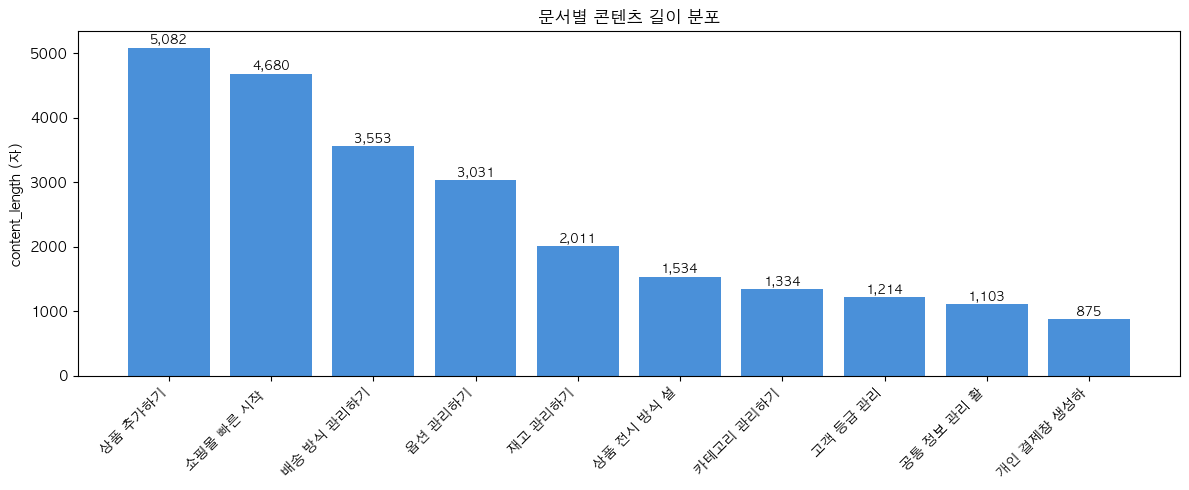

In [45]:
sorted_docs = sorted(documents, key=lambda d: -d["content_length"]) # 문서를 길이 내림차순으로 정렬
sorted_lengths = [d["content_length"] for d in sorted_docs]
labels = [d["title"][:10] for d in sorted_docs]

plt.figure(figsize=(12, 5)) # 차트 크기 지정
bars = plt.bar(range(len(sorted_docs)), sorted_lengths, color="#4A90D9") # 막대그래프 생성
plt.title("문서별 콘텐츠 길이 분포")
plt.xticks(range(len(sorted_docs)), labels, rotation=45, ha="right", fontsize=10)
plt.ylabel("content_length (자)")

for bar, length in zip(bars, sorted_lengths):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        f"{length:,}",
        ha="center",
        fontsize=9,
    )

plt.tight_layout() # 여백 자동 조정
plt.show() # 차트 렌더링

페이지마다 콘텐츠 길이의 차이가 많이 나는 것을 확인할 수 있습니다.  

페이지 단위로 청킹하면 5,082자의 문서와 782자의 문서 모두 각각 하나의 벡터가 됩니다.    
긴 문서는 여러 내용이 섞여 벡터가 평균화되고, 짧은 문서는 주제가 명확해 벡터가 선명해집니다.   
길이 편차가 크면 임베딩 품질이 둘쭉날쭉할 가능성이 있습니다.    

페이지 단위로 청킹하여 실제 평가 결과를 확인해보겠습니다.

## 3. 공통 함수 정의

### 1) 벡터 저장소 구축

전략별로 `vector_stores[strategy_name]` 딕셔너리에 분리 보관

In [ ]:
vector_stores = {}

### 2) 임베딩

인메모리 numpy 배열로 벡터를 저장한다.  


**임베딩(Embedding)**: 텍스트를 고정 길이의 숫자 배열(벡터)로 변환하는 것. 의미가 비슷한 텍스트는 비슷한 벡터가 된다.  
**벡터(Vector)**: 임베딩의 결과물. 여기서는 1536개의 숫자로 이루어진 배열. 벡터 간 코사인 유사도로 "의미적 거리"를 계산한다.

**numpy 배열이란?**  
Python 메모리에 올라간 숫자 행렬. 여기서는 10행 × 1536열짜리 숫자표가 된다.
```
청크 0: [0.12, 0.45, -0.03, ..., 0.78]  ← 1536개
청크 1: [0.78, 0.11, 0.55, ..., 0.33]  ← 1536개
...
청크 9: [0.33, 0.21, 0.67, ..., 0.12]  ← 1536개
```

일반 Python 리스트로도 저장 가능하지만, `cosine_similarity()` 같은 수학 연산이 numpy 배열을 입력으로 받고, numpy가 내부적으로 C로 구현되어 있어 벡터 연산이 빠르다.  
실제 서비스(프로덕션)에서는 pgvector, Pinecone 같은 벡터 DB를 쓰지만, 10개 문서 실험에는 numpy로 충분하다.

**`embed_texts(texts)`** — 텍스트 여러 개를 한 번에 임베딩 (배치)
- `client.embeddings.create(input=texts)` → OpenAI API에 텍스트 리스트 전송
- API가 각 텍스트를 1536차원 벡터로 변환하여 반환
- 입력: `["고객 등급 관리 문서 전문...", "옵션 관리 문서 전문..."]`
- 출력: `[[0.12, 0.45, ...], [0.78, 0.11, ...]]` (각 1536차원)

**`embed_text(text)`** — 텍스트 1개를 임베딩. 검색 시 질문을 벡터로 변환할 때 사용.
- 내부적으로 `embed_texts([text])[0]`을 호출
- 입력: `"VIP 고객 등급 기준을 변경하고 싶어요"`
- 출력: `[0.33, 0.21, ...]` (1536차원 벡터 1개)

In [ ]:
def embed_texts(texts, model=EMBEDDING_MODEL):
    """OpenAI 임베딩 API 배치 호출."""
    response = client.embeddings.create(input=texts, model=model)
    return [item.embedding for item in response.data]


def embed_text(text, model=EMBEDDING_MODEL):
    """단일 텍스트 임베딩."""
    return embed_texts([text], model)[0]

### 3) 검색 함수

질문(query)을 임베딩한 뒤, 벡터 저장소의 모든 청크와 코사인 유사도를 계산하여 가장 유사한 top-k개를 반환한다.

**임베딩**

```python
query_emb = np.array(embed_text(query)).reshape(1, -1)
```

- 질문 텍스트를 1536차원 벡터로 변환.
- `.reshape(1, -1)`은 1차원 배열 `[0.12, 0.45, ...]`을 2차원 `[[0.12, 0.45, ...]]`로 바꿈.  
- `cosine_similarity()`가 2차원 입력을 요구하기 때문.

**유사도 계산**

```python
sims = cosine_similarity(query_emb, store["embeddings"])[0]
```

- 질문 벡터와 저장소의 모든 청크 벡터 사이의 유사도를 한번에 계산
- 반환값은 2차원 배열 `[[0.57, 0.42, 0.40, 0.38, 0.35, 0.33, 0.30, 0.28, 0.25, 0.20]]`
  - 질문의 개수만큼 행이 구성되며, 여기서는 질문이 1개이므로 결과 행도 1개 -> `[0]`으로 질문 1개에 대한 행만 참조하는 것
- 결과: `[0.57, 0.42, 0.40, ...]` — 각 청크와의 유사도 점수 (0~1)

**유사한 상위 k개 필터링**

```python
top_k = np.argsort(sims)[::-1][:k]
```

- `np.argsort(sims)` → 유사도를 오름차순 정렬한 **인덱스** 배열  
- `[::-1]` → 뒤집어서 내림차순 (가장 유사한 것이 앞으로)  
- `[:k]` → 상위 k개만 선택

In [ ]:
def search(query, store, k=3):
    """코사인 유사도 기반 top-k 검색."""
    query_emb = np.array(embed_text(query)).reshape(1, -1)
    sims = cosine_similarity(query_emb, store["embeddings"])[0]
    top_k = np.argsort(sims)[::-1][:k]

    results = []
    for i in top_k:
        results.append({
            "rank": len(results) + 1,
            "title": store["chunks"][i]["title"],
            "source_url": store["chunks"][i]["source_url"],
            "score": float(sims[i]),
            "text_preview": store["chunks"][i]["text"][:150],
        })
    return results


def print_results(query, results):
    """검색 결과를 보기 좋게 출력한다."""
    print(f"질문: {query}")
    print("-" * 70)
    for r in results:
        print(f"  {r['rank']}. [{r['score']:.4f}] {r['title']}")
        print(f"     {r['text_preview'][:80]}...")
    print()

### 4) 평가 메트릭

전략 간 비교를 위한 자동 평가 함수.  
평가셋(eval_dataset)이 준비되면 아래 함수로 Hit Rate, MRR, MAP을 계산한다.

**Hit Rate**: 정답이 있는지 여부 (0 or 1)
- top-K 결과 중 정답 URL이 하나라도 있으면 1, 없으면 0 (가장 단순)

**MRR**: 정답이 몇 위에 있었는지 (0~1)
- 첫 번째 정답의 역수 순위를 취함
- 예를 들어 3개 중 
  - 정답이 1위면 1/1 = 1.0
  - 정답이 2위면 1/2 = 0.5
  - 정답이 3위면 1/3 = 0.33
  - 정답이 없으면 = 0.0
- 순위가 높을수록 높은 점수

**Average Precision**: 정답이 여러 개일 때 순위 전체를 반영
- 정답을 만날 때마다 '여기까지의 정밀도(precision)'를 누적
- 예를 들어 정답이 `{A, C}`인데, top-5의 결과가 `[A, X, C, X, X]`라면,
  - i=0: A는 정답 -> hits=1, precision=1/1=1.0 -> 누적 1.0
  - i=1: X는 오답 -> skip
  - i=2: C는 정답 -> hits=2, precision=2/3=0.67 -> 누적 1.67
  - i=3: X는 오답 -> skip
  - i=4: X는 오답 -> skip
  -> AP = 1.67 / min(2, 5) = 1.67 / 2 = 0.835
- 예를 들어 정답이 `{A, C}`인데, top-5의 결과가 `[X, X, A, X, C]`라면,
  - i=0: X는 오답 -> skip
  - i=1: X는 오답 -> skip
  - i=2: A는 정답 -> hits=1, precision=1/3=0.33 -> 누적 0.33
  - i=3: X는 오답 -> skip
  - i=4: C는 정답 -> hits=2, precision=2/5=0.40 -> 누적 0.73
  -> AP = 0.73 / min(2, 5) = 0.73 / 2 = 0.365
- 즉, 정답이 앞에 몰려 있을수록 점수가 높아지는 구조
- MRR은 첫 번째 정답만 보지만 AP는 모든 정답의 위치를 반영

In [ ]:
def hit_rate(results, ground_truth_urls, k):
    """top-k 안에 정답이 하나라도 있으면 1, 없으면 0."""
    retrieved = [r["source_url"] for r in results[:k]]
    return 1.0 if any(url in ground_truth_urls for url in retrieved) else 0.0


def mrr(results, ground_truth_urls, k):
    """첫 번째 정답의 역수 순위."""
    for i, r in enumerate(results[:k]):
        if r["source_url"] in ground_truth_urls:
            return 1.0 / (i + 1)
    return 0.0


def average_precision(results, ground_truth_urls, k):
    """Average Precision: 정답이 여러 개일 때 순위 전체를 반영."""
    hits = 0
    sum_precisions = 0.0
    for i, r in enumerate(results[:k]):
        if r["source_url"] in ground_truth_urls:
            hits += 1
            sum_precisions += hits / (i + 1)
    if not ground_truth_urls:
        return 0.0
    return sum_precisions / min(len(ground_truth_urls), k)


def evaluate(store, eval_dataset, k_values=(1, 3, 5)):
    """전략 하나에 대해 전체 평가셋으로 메트릭을 계산한다."""
    metrics = {}
    for k in k_values:
        hr_scores = []
        mrr_scores = []
        map_scores = []

        for item in eval_dataset:
            results = search(item["question"], store, k=k)
            gt = set(item["relevant_doc_urls"])

            hr_scores.append(hit_rate(results, gt, k))
            mrr_scores.append(mrr(results, gt, k))
            map_scores.append(average_precision(results, gt, k))

        metrics[k] = {
            "hit_rate": np.mean(hr_scores),
            "mrr": np.mean(mrr_scores),
            "map": np.mean(map_scores),
        }
    return metrics


print("평가 함수 정의 완료. eval_dataset 준비 후 evaluate() 호출.")

## 4. 평가셋 로드

In [ ]:
_POSITIVE_RAW = """
[
  {
    "question": "PG 신청하면 결제 오픈까지 얼마나 걸려?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/shoppingmall-start"
    ],
    "difficulty": "easy",
    "evidence": "신청만 하셔도 6분 만에 일시불 카드 결제가 오픈됩니다! (미리 오픈)"
  },
  {
    "question": "도메인 연결 후 적용되기까지 시간이 얼마나 걸리나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/shoppingmall-start"
    ],
    "difficulty": "easy",
    "evidence": "이 네임서버를 도메인 구매처에 입력하면 약 24시간 이내 연결됩니다."
  },
  {
    "question": "네이버페이 주문형이랑 결제형 둘 다 쓰고 싶은데 어떤 순서로 신청해야 하나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/shoppingmall-start"
    ],
    "difficulty": "medium",
    "evidence": "주문형/결제형을 모두 이용하시려면 주문형 → 결제형 순으로 진행해 주셔야 정산 주기 협의에 유리해요."
  },
  {
    "question": "검색 엔진에 내 쇼핑몰 노출시키는 방법",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/shoppingmall-start"
    ],
    "difficulty": "medium",
    "evidence": "[설정 > 외부 서비스]에서 네이버 웹마스터/구글 서치 콘솔 항목에 HTML 태그 값을 입력해 두면 약 2-4주 이내 사이트가 검색 엔진에 노출됩니다."
  },
  {
    "question": "쇼핑몰 처음 만드는데, 상품 등록하고 PG 신청 전에 디자인부터 완성해야 해?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/shoppingmall-start"
    ],
    "difficulty": "hard",
    "evidence": "디자인은 심사 요소가 아니기 때문에, 우선 PG부터 신청하고 디자인을 해 주시는 편이 좋아요."
  },
  {
    "question": "등급 이름 최대 몇 자까지 설정 가능해?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/customers/grade"
    ],
    "difficulty": "easy",
    "evidence": "등급의 이름입니다. 최대 100자 설정할 수 있습니다."
  },
  {
    "question": "등급 할인 혜택 정액과 정률 차이가 뭔가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/customers/grade"
    ],
    "difficulty": "easy",
    "evidence": "정액(원): 매 주문마다 정해진 할인 금액이 적용됩니다. 정률(%): 매 주문마다 정해진 할인율이 적용됩니다."
  },
  {
    "question": "고객 등급 수동으로 바꾸는 방법",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/customers/grade"
    ],
    "difficulty": "medium",
    "evidence": "[식스샵 프로 > 고객 관리 > 고객]에서 대상 고객을 ✓(체크박스) 선택 후, 상단의 등급 변경 버튼을 클릭하여 등급을 조정할 수 있습니다."
  },
  {
    "question": "추가 적립금 기능을 쓰려면 미리 설정해둬야 하는 게 있나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/customers/grade"
    ],
    "difficulty": "medium",
    "evidence": "[설정 > 적립금 설정]에 구매 적립금을 설정한 상태에서만 추가 적립금을 설정할 수 있습니다."
  },
  {
    "question": "고객이 연결되어 있는 등급을 삭제하고 싶은데 바로 삭제가 안 돼요. 어떻게 해야 하나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/customers/grade"
    ],
    "difficulty": "hard",
    "evidence": "해당 등급에 연결된 고객이 없는 상태에서만 삭제가 가능합니다. 연결된 고객이 있다면 모두 다른 등급으로 변경한 후 진행해 주세요."
  },
  {
    "question": "상품 이미지 최대 몇 개까지 등록할 수 있나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/add-product"
    ],
    "difficulty": "easy",
    "evidence": "최대 30개의 이미지를 등록할 수 있어요."
  },
  {
    "question": "상품 추가 시 필수 입력 항목",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/add-product"
    ],
    "difficulty": "easy",
    "evidence": "상품을 추가하려면 반드시 입력해야 하는 항목입니다. 기본 정보 - 상품 이름 / 가격 정보 - 정가 / 배송 정보"
  },
  {
    "question": "배송이 필요 없는 서비스 상품을 등록하려면 어떻게 설정해야 해?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/add-product"
    ],
    "difficulty": "medium",
    "evidence": "배송 설정 안 함: 배송을 하지 않는 서비스 상품인 경우 선택해 주세요."
  },
  {
    "question": "상품 URL을 직접 지정하는 방법이 있나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/add-product"
    ],
    "difficulty": "medium",
    "evidence": "직접 입력: 영어 소문자, 숫자, -, _를 사용하여 직접 입력할 수 있어요. (최대 50자, 공백 제외)"
  },
  {
    "question": "상품을 등록했는데 사이트에 안 보이고, 네이버페이로도 결제가 안 돼요. 비배송 상품인데 뭐가 문제일까요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/add-product"
    ],
    "difficulty": "hard",
    "evidence": "카테고리를 설정해야 웹사이트에 상품이 노출됩니다. / 비배송 상품은 네이버페이 주문형 정책에 따라 네이버페이로 구매할 수 없습니다."
  },
  {
    "question": "카테고리 최대 몇 차까지 만들 수 있어?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/category"
    ],
    "difficulty": "easy",
    "evidence": "최대 4차 카테고리까지 설정할 수 있습니다."
  },
  {
    "question": "여러 상품에 카테고리를 한꺼번에 적용하는 방법",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/category"
    ],
    "difficulty": "medium",
    "evidence": "[식스샵 프로 > 상품 관리 > 상품]에서 카테고리를 적용할 상품 선택 후 상단의 일괄 변경을 클릭하고 카테고리 선택"
  },
  {
    "question": "카테고리를 수정했는데 사이트에 반영이 안 되는 것 같아요. 어떻게 해야 하나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/category"
    ],
    "difficulty": "medium",
    "evidence": "편집한 상품 카테고리는 디자인 에디터 진입 시점에 업데이트됩니다. 만약 상품 카테고리를 편집하였는데 해당 내용이 웹사이트에 반영되지 않는다면 [식스샵 프로 > 채널 관리 - 웹사이트]에서 디자인 편집하기를 클릭하여 에디터에 접속해 주세요."
  },
  {
    "question": "이미 카테고리가 10개 등록된 상품에 일괄로 카테고리를 추가하면 어떻게 돼?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/category"
    ],
    "difficulty": "hard",
    "evidence": "이미 상품에 카테고리가 10개가 등록되어 있거나 등록된 카테고리를 추가할 경우 카테고리가 수정되지 않습니다."
  },
  {
    "question": "SKU 코드가 뭐야?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/stock-keeping-unit"
    ],
    "difficulty": "easy",
    "evidence": "SKU 코드는 Stock Keeping Unit의 약자로, 각 사업체에서 취급하는 상품 중 최소 단위의 재고를 구분하기 위한 고유한 코드예요."
  },
  {
    "question": "재고 수량 일괄 변경 처리 시간",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/stock-keeping-unit"
    ],
    "difficulty": "easy",
    "evidence": "600개를 일괄 변경할 경우 대략 1분 이상 소요돼요."
  },
  {
    "question": "옵션은 다른데 재고는 같이 공유하게 설정하고 싶은데 가능한가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/stock-keeping-unit"
    ],
    "difficulty": "medium",
    "evidence": "자동 생성한 재고 하나를 선택한 세부 품목에 연결 - 구매 옵션이 달라도 공통 재고 수량만 감소되는 경우 선택해 주세요."
  },
  {
    "question": "재고 수량을 한꺼번에 바꿨는데 일부만 실패했어. 실패한 항목은 어디서 확인해?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/stock-keeping-unit"
    ],
    "difficulty": "medium",
    "evidence": "일부 재고 수량 변경에 실패하면 우측 하단 작업 관리자에서 내역을 확인할 수 있으며, 실패한 항목은 엑셀 파일로 내려받을 수 있어요."
  },
  {
    "question": "SKU 코드 없이 재고를 등록하고 싶은데, SKU 코드를 직접 안 만들어도 재고 관리가 가능한가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/stock-keeping-unit"
    ],
    "difficulty": "hard",
    "evidence": "SKU 코드 설정이 어렵거나, 여러 세부 품목의 재고를 한 번에 생성할 때 SKU 코드가 자동으로 생성돼서 편리해요."
  },
  {
    "question": "옵션 이름 최대 몇 개까지 추가 가능한가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/options"
    ],
    "difficulty": "easy",
    "evidence": "옵션 이름은 최대 5개까지 추가할 수 있습니다."
  },
  {
    "question": "세부 품목 최대 개수",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/options"
    ],
    "difficulty": "easy",
    "evidence": "세부 품목은 최대 600개까지 추가할 수 있습니다."
  },
  {
    "question": "각인 문구처럼 구매자가 직접 텍스트를 입력하는 옵션은 어떻게 만들어?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/options"
    ],
    "difficulty": "medium",
    "evidence": "텍스트 형식으로 구매자가 직접 입력하는 옵션이라면, 작성형 옵션을 활용합니다."
  },
  {
    "question": "다른 상품에 이미 설정한 옵션을 새 상품에 그대로 가져오는 방법",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/options"
    ],
    "difficulty": "medium",
    "evidence": "다른 상품의 옵션 및 추가 옵션을 불러와 편리하게 상품을 수정/등록할 수 있습니다. / 불러오는 상품의 옵션/추가 옵션으로 덮어 씌워집니다."
  },
  {
    "question": "추가 옵션을 필수가 아니라 선택 입력으로 하고 싶은데, 선택형 옵션에서 선택 안 함을 구현할 방법이 있나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/options"
    ],
    "difficulty": "hard",
    "evidence": "추가 옵션은 현재 '필수 입력'으로만 제공이 되기 때문에, [선택형 옵션]일 때 제공되는 옵션 외에 [선택 안 함](추가금 +0원)이라는 옵션을 별도로 추가합니다."
  },
  {
    "question": "배송비 부과 유형 종류",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/shipping"
    ],
    "difficulty": "easy",
    "evidence": "배송비 무료, 고정 배송비, 조건부 무료 배송비 중 원하는 유형을 선택해 주세요."
  },
  {
    "question": "배송비 묶음 설정은 어디서 하나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/shipping"
    ],
    "difficulty": "easy",
    "evidence": "[관리 홈 > 설정 > 배송 방식 설정] 오른쪽 상단의 배송비 묶음 설정을 눌러 설정할 수 있어요."
  },
  {
    "question": "조건부 무료 배송인데 제주도로 보내면 배송비가 어떻게 계산돼?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/shipping"
    ],
    "difficulty": "medium",
    "evidence": "배송비 무료 조건을 달성하는 경우, 추가 배송비만 부과됩니다."
  },
  {
    "question": "배송 방식이 다른 상품을 같이 주문할 때 배송비를 한 번만 받고 싶은데 가능한가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/shipping"
    ],
    "difficulty": "medium",
    "evidence": "구매자가 배송 방식이 다른 상품을 함께 장바구니에 담아 결제할 경우, 가장 큰 배송비 1회 또는 가장 작은 배송비 1회만 부과하도록 설정할 수 있는 기능입니다."
  },
  {
    "question": "무료배송 상품이랑 유료배송 상품을 같이 담았을 때 배송비 묶음을 '가장 작은 배송비'로 설정하면 배송비가 0원이 되나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/shipping"
    ],
    "difficulty": "hard",
    "evidence": "'가장 작은 배송비 부과'로 설정한 경우, 무료배송(0원)이 가장 작은 금액이므로 최종 배송비는 0원이에요."
  },
  {
    "question": "상품 단위 전시와 옵션 단위 전시 차이가 뭐야?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/display-settings"
    ],
    "difficulty": "easy",
    "evidence": "상품 단위: 웹사이트의 상품 목록에서 상품을 클릭하여 상품 상세 페이지에서 옵션을 선택할 수 있는 기본적인 상품 전시 방식 / 옵션 단위: 웹사이트의 상품 목록에서 상품의 옵션을 기준으로 상품이 전시됩니다."
  },
  {
    "question": "옵션 단위 전시 시 상품 이름이 어떻게 노출되나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/display-settings"
    ],
    "difficulty": "easy",
    "evidence": "상품 이름-옵션 값으로 상품 이름이 전시됩니다."
  },
  {
    "question": "상품 옵션을 수정했더니 전시 방식이 상품 단위로 바뀌었어요. 왜 그런 건가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/display-settings"
    ],
    "difficulty": "medium",
    "evidence": "상품의 옵션이나 세부 품목을 수정 또는 삭제 시 별도 알림 없이 설정한 전시 방식이 초기화되어 상품 단위 전시 방식으로 노출됩니다."
  },
  {
    "question": "옵션 단위로 전시할 때 일부 세부 품목만 품절이면 상품 목록에서 품절 표시가 되나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/display-settings"
    ],
    "difficulty": "hard",
    "evidence": "기준이 되는 옵션의 세부 품목의 판매 상태가 모두 일시 품절이거나 연결된 재고가 0인 경우, 웹사이트에서 품절로 표시됩니다. 기준이 되는 옵션 중 일부 세부 품목만 일시 품절일 경우, 품절 표시가 되지 않지만, 상품 상세 페이지에서 해당 옵션 선택 시 품절로 표시되어 구매할 수 없어요."
  },
  {
    "question": "공통 정보 상세 설명 최대 글자 수",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/info-preset"
    ],
    "difficulty": "easy",
    "evidence": "공통 정보 상세 설명은 HTML 기준 최대 5만 자까지 입력할 수 있어요."
  },
  {
    "question": "공통 정보를 삭제하면 연결된 상품은 어떻게 되나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/info-preset"
    ],
    "difficulty": "medium",
    "evidence": "삭제하기를 클릭하면 선택한 공통 정보는 삭제되며, 연결한 상품에서도 적용 해제됩니다."
  },
  {
    "question": "배송/교환/반품 안내를 여러 상품에 공통으로 넣고 싶은데, 나중에 내용을 수정하면 연결된 상품에도 자동 반영돼?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/info-preset"
    ],
    "difficulty": "medium",
    "evidence": "수정하기 에서 등록된 공통 정보를 수정하면 연결되어 있는 상품에 반영됩니다."
  },
  {
    "question": "외부 채널로 상품을 연동했는데 머리글/바닥글에 설정한 공통 정보가 안 보여요. 왜 그런 건가요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/info-preset"
    ],
    "difficulty": "hard",
    "evidence": "상품 연동 관리로 가져온 상품이나, 사방넷 등의 외부 채널 이용 시 상품 설명 중 상세 설명만 반영되고, 머리글과 바닥글에 연결한 공통 정보는 반영되지 않습니다."
  },
  {
    "question": "개인 결제창 생성 방법",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/personal-payment"
    ],
    "difficulty": "easy",
    "evidence": "'상품'을 추가하는 방식으로 특정 고객에게만 개인 결제창을 제공할 수 있습니다. Step 1. [식스샵 프로 > 상품 관리 > 상품]에서 오른쪽 상단 상품 추가하기를 클릭해 주세요."
  },
  {
    "question": "개인 결제창 상품 카테고리를 왜 미분류로 해야 하나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/personal-payment"
    ],
    "difficulty": "medium",
    "evidence": "카테고리가 '미분류'(선택 안 함) 상태여야 지정된 고객에게만 상품 정보가 노출되니 유의해 주세요."
  },
  {
    "question": "특정 고객한테만 따로 결제 링크 보내고 싶은데 어떻게 해?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/personal-payment"
    ],
    "difficulty": "medium",
    "evidence": "'상품'을 추가하는 방식으로 특정 고객에게만 개인 결제창을 제공할 수 있습니다. 추가된 상품 오른쪽 •••를 클릭 후 웹사이트에서 보기를 클릭 후 새 창에서 확인되는 개인 결제 창의 URL을 고객에게 전달하여 결제를 요청해 주세요."
  },
  {
    "question": "개인 결제창 URL을 복사했는데 기본 도메인으로 나와요. 커스텀 도메인으로 바꿔서 보내도 되나요?",
    "relevant_doc_urls": [
      "https://help.pro.sixshop.com/products/personal-payment"
    ],
    "difficulty": "hard",
    "evidence": "복사한 URL은 커스텀 도메인 기반으로 변환 후 공유하시길 권장합니다. 000.sixshop.site 형식의 기본 도메인을 실제 사용 중인 상점의 도메인으로 치환해 주시면 됩니다."
  }
]
"""
_NEGATIVE_RAW = """
[
  {
    "question": "고객이 주문 취소를 요청하는데 환불 처리는 어떻게 해야 하나요?",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "주문 상태를 일괄 변경하는 방법이 있나요?",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "쇼핑몰 디자인 테마 변경 어떻게 해?",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "다국어 설정 영어 일본어 지원",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "세금계산서 자동 발행 설정 방법",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "회원 탈퇴 처리 어떻게 해?",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "매출 통계 리포트 확인 방법",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "고객 문의 게시판 답변은 어디서 하나요?",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "적립금 자동 지급 설정",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  },
  {
    "question": "상품 리뷰에 악성 댓글이 달렸는데 삭제하거나 숨길 수 있어?",
    "relevant_doc_urls": [],
    "difficulty": "negative"
  }
]
"""
positive = json.loads(_POSITIVE_RAW)
negative = json.loads(_NEGATIVE_RAW)

# evidence 필드 제거 (검증용이었으므로)
for item in positive:
    item.pop("evidence", None)

eval_dataset = positive + negative

print(f"positive: {len(positive)}개, negative: {len(negative)}개, 합계: {len(eval_dataset)}개")

positive: 46개, negative: 10개, 합계: 56개


## 5. Strategy 1: 페이지 단위 (baseline)

가장 단순한 방식. 문서 전체를 하나의 청크로 사용한다.  
분할하지 않으므로 **청크 수 = 문서 수**.

### 1) 청킹

문서 전체를 하나의 청크로 사용합니다.

In [ ]:
def chunk_page_level(documents):
    chunks = []
    for doc in documents:
        chunks.append({
            "text": doc["content"],
            "source_url": doc["url"],
            "title": doc["title"],
        })
    return chunks


chunks = chunk_page_level(documents)

print(f"청크 수: {len(chunks)} (= 문서 수)")
print()
for c in chunks:
    print(f"  [{len(c['text']):>5}자] {c['title']}")

**Q. 왜 `documents`를 그대로 안 쓰고 `chunks`로 변환하나요?**

1. **전략 간 통일된 포맷**
    - 모든 전략의 청크가 `{"text", "source_url", "title"}` 3개 필드만 가짐.  
    - Strategy 2부터는 하나의 문서가 여러 청크로 쪼개져서 원본 `documents`와 구조가 달라지지만, `search()`, `evaluate()` 같은 공통 함수는 전략에 관계없이 동일한 필드에 접근할 수 있음.

2. **불필요한 필드 제거**
    - 원본 JSON의 `content_length`, `breadcrumb` 등은 검색/임베딩에 불필요. 벡터 저장소에 넣을 데이터만 남김.

### 2) 임베딩 + 벡터 저장소 구축

In [ ]:
texts = [c["text"] for c in chunks] # 여기서 c가 하나의 페이지 내용 전체. 페이지 내용에서 text만 추출하여 임베딩
embeddings = embed_texts(texts)

vector_stores["page_level"] = {
    "chunks": chunks,
    "embeddings": np.array(embeddings),
}

print(f"벡터 저장소 구축 완료")
print(f"  청크 수: {len(chunks)}")
print(f"  임베딩 shape: {vector_stores['page_level']['embeddings'].shape}")

### 3) 평가

LLM으로 생성한 평가셋으로 baseline 성능을 측정한다.

#### a. Positive 메트릭 계산

positive 질문만으로 Hit Rate, MRR, MAP을 계산한다.

**Q. 왜 positive와 negative 평가셋을 따로 evaluate하는가?**

hit_rate, mrr, map 모두 "정답 URL이 결과에 있는가"를 측정하는 메트릭입니다.  
negative는 relevant_doc_urls: []이므로 항상 hit_rate=0, mrr=0, map=0이 나옵니다.  
섞으면 점수가 희석되어 의미 없는 수치가 되므로 분리해서 평가합니다.

In [92]:
# positive만으로 메트릭 계산 (hit_rate, mrr, map은 정답이 있는 질문에만 의미 있음)
store_page = vector_stores["page_level"]
metrics = evaluate(store_page, positive, k_values=(1, 3, 5))

print("Strategy 1: 페이지 단위 (baseline)")
print("=" * 45)
print(f"{'k':>3} | {'Hit Rate':>10} | {'MRR':>10} | {'MAP':>10}")
print("-" * 45)
for k, m in metrics.items():
    print(f"{k:>3} | {m['hit_rate']:>10.4f} | {m['mrr']:>10.4f} | {m['map']:>10.4f}")

Strategy 1: 페이지 단위 (baseline)
  k |   Hit Rate |        MRR |        MAP
---------------------------------------------
  1 |     0.7609 |     0.7609 |     0.7609
  3 |     0.9565 |     0.8514 |     0.8514
  5 |     0.9783 |     0.8569 |     0.8569


**결과 분석:**

- **k=1에서 세 지표가 모두 동일한 이유**: 결과가 1개뿐이면 hit_rate(맞으면 1, 틀리면 0), mrr(맞으면 1/1, 틀리면 0), map(맞으면 1/1, 틀리면 0)이 모두 같은 계산이 됨. k=3부터 순위가 생기면서 지표 간 차이가 나타남.
- **k=1 Hit Rate 0.76**: 46개 질문 중 76% (약 35개)가 1위로 정답 문서를 찾았고, 24% (약 11개)는 1위가 오답. 실제 RAG에서는 보통 top-1~3을 LLM에 넘기는데, 0.76이면 4번 중 1번은 엉뚱한 문서를 넘기는 셈.
- **k=3 Hit Rate 0.957**: 거의 대부분(46개 중 2개만 miss)이 top-3 안에 정답이 있음. 단, 문서가 10개뿐이니 top-3이면 30%를 보는 셈이라 높게 나오는 것이 자연스러움.
- **MRR@3 0.851**: 정답의 평균 순위가 약 1.2위 (1/0.85 ≈ 1.18). 대부분 1위지만 일부가 2~3위로 밀림.

청킹 전략 개선 후 **k=1 Hit Rate가 0.85~0.90+**로 올라가면 유의미한 개선이라고 판단할 수 있다.

#### b. Negative 유사도 점수 확인

negative 질문은 문서에 답이 없으므로, 메트릭 대신 top-1 유사도 점수(검색 결과의 유사도 점수)가 낮은지를 확인합니다.

In [93]:
# negative 질문: 유사도 점수 확인 (정답이 없으니 score가 낮아야 정상)
for item in negative:
    results = search(item["question"], store_page, k=1)
    score = results[0]["score"]
    print(f"[{score:.4f}] {item['question'][:40]}... → {results[0]['title']}")

[0.4416] 고객이 주문 취소를 요청하는데 환불 처리는 어떻게 해야 하나요?... → 개인 결제창 생성하기
[0.4500] 주문 상태를 일괄 변경하는 방법이 있나요?... → 재고 관리하기
[0.3885] 쇼핑몰 디자인 테마 변경 어떻게 해?... → 카테고리 관리하기
[0.2476] 다국어 설정 영어 일본어 지원... → 상품 전시 방식 설정하기
[0.3596] 세금계산서 자동 발행 설정 방법... → 재고 관리하기
[0.2980] 회원 탈퇴 처리 어떻게 해?... → 개인 결제창 생성하기
[0.3586] 매출 통계 리포트 확인 방법... → 쇼핑몰 빠른 시작 가이드
[0.3835] 고객 문의 게시판 답변은 어디서 하나요?... → 쇼핑몰 빠른 시작 가이드
[0.3455] 적립금 자동 지급 설정... → 옵션 관리하기
[0.3555] 상품 리뷰에 악성 댓글이 달렸는데 삭제하거나 숨길 수 있어?... → 공통 정보 관리 활용하기


#### c. Positive vs Negative 점수 분포 비교

두 분포가 겹칠수록 '답이 있다/없다'를 점수만으로 구분하기 어렵다.

In [94]:
# positive 질문들의 top-1 유사도 점수
pos_scores = []
for item in positive:
    results = search(item["question"], store_page, k=1)
    pos_scores.append(results[0]["score"])

# negative 질문들의 top-1 유사도 점수
neg_scores = []
for item in negative:
    results = search(item["question"], store_page, k=1)
    neg_scores.append(results[0]["score"])

print(f"positive top-1 score: min={min(pos_scores):.4f}, mean={np.mean(pos_scores):.4f}, max={max(pos_scores):.4f}")
print(f"negative top-1 score: min={min(neg_scores):.4f}, mean={np.mean(neg_scores):.4f}, max={max(neg_scores):.4f}")

positive top-1 score: min=0.2587, mean=0.5051, max=0.6610
negative top-1 score: min=0.2476, mean=0.3628, max=0.4500


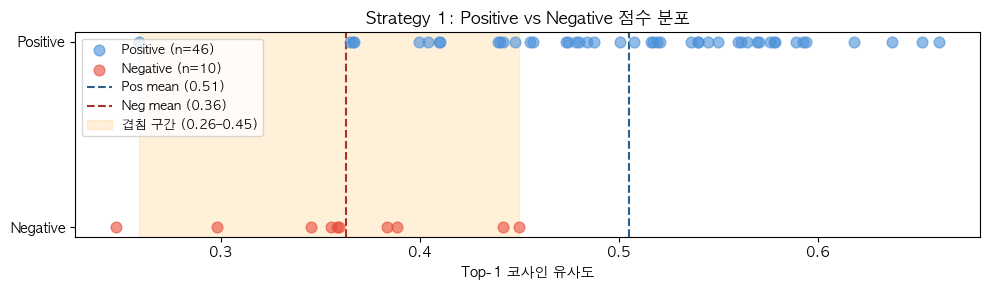

In [95]:
plt.figure(figsize=(10, 3))

plt.scatter(pos_scores, [1] * len(pos_scores), alpha=0.6, s=60, color="#4A90D9", label=f"Positive (n={len(pos_scores)})", zorder=3)
plt.scatter(neg_scores, [0] * len(neg_scores), alpha=0.6, s=60, color="#E74C3C", label=f"Negative (n={len(neg_scores)})", zorder=3)

plt.axvline(np.mean(pos_scores), color="#2C5F8A", linestyle="--", linewidth=1.5, label=f"Pos mean ({np.mean(pos_scores):.2f})")
plt.axvline(np.mean(neg_scores), color="#A93226", linestyle="--", linewidth=1.5, label=f"Neg mean ({np.mean(neg_scores):.2f})")

overlap_min = max(min(neg_scores), min(pos_scores))
overlap_max = min(max(neg_scores), max(pos_scores))
plt.axvspan(overlap_min, overlap_max, alpha=0.15, color="orange", label=f"겹침 구간 ({overlap_min:.2f}–{overlap_max:.2f})")

plt.xlabel("Top-1 코사인 유사도")
plt.yticks([0, 1], ["Negative", "Positive"])
plt.title("Strategy 1: Positive vs Negative 점수 분포")
plt.legend(fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

**결과 분석:**

- **negative max(0.45) < positive mean(0.51)**: 답이 없는 질문의 최고 점수가 답이 있는 질문의 평균보다 낮음. 0.45~0.50 사이에 임계값을 설정하면 어느 정도 분리가 가능.
- **positive min(0.26)이 negative 수준**: 답이 있는데도 매우 낮은 점수를 받는 질문이 있음. 4,680자 "쇼핑몰 빠른 시작 가이드"에서 도메인 관련 내용이 한 문단뿐이라 벡터가 희석된 결과.
- **Gap = 0.14** (positive mean 0.51 - negative mean 0.36): 청킹으로 이 gap이 더 벌어지는지 확인한다.

#### d. 오답 분석 

점수가 낮은 질문을 확인하여 페이지 단위 임베딩의 약점을 파악한다.

In [83]:
# URL → title 매핑
url_to_title = {doc["url"]: doc["title"] for doc in documents}

scored = []
for item in positive:
    results = search(item["question"], store_page, k=1)
    expected_url = item["relevant_doc_urls"][0]
    scored.append({
        "score": results[0]["score"],
        "question": item["question"],
        "expected": url_to_title.get(expected_url, expected_url),
        "got": results[0]["title"],
        "hit": results[0]["source_url"] in item["relevant_doc_urls"],
    })

scored.sort(key=lambda x: x["score"])

print("하위 10개 (점수 낮은 순)")
print("-" * 80)
for s in scored[:10]:
    marker = "O" if s["hit"] else "X"
    print(f"[{marker}] [{s['score']:.4f}] {s['question'][:45]}")
    print(f"         기대: {s['expected']} → 결과: {s['got']}")

하위 10개 (점수 낮은 순)
--------------------------------------------------------------------------------
[O] [0.2587] 도메인 연결 후 적용되기까지 시간이 얼마나 걸리나요?
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[X] [0.3647] SKU 코드가 뭐야?
         기대: 재고 관리하기 → 결과: 상품 추가하기
[X] [0.3667] 세부 품목 최대 개수
         기대: 옵션 관리하기 → 결과: 상품 전시 방식 설정하기
[X] [0.3668] PG 신청하면 결제 오픈까지 얼마나 걸려?
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 개인 결제창 생성하기
[O] [0.3996] 상품 이미지 최대 몇 개까지 등록할 수 있나요?
         기대: 상품 추가하기 → 결과: 상품 추가하기
[O] [0.4041] 검색 엔진에 내 쇼핑몰 노출시키는 방법
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[O] [0.4098] 고객이 연결되어 있는 등급을 삭제하고 싶은데 바로 삭제가 안 돼요. 어떻게 해야 
         기대: 고객 등급 관리 → 결과: 고객 등급 관리
[O] [0.4100] 공통 정보 상세 설명 최대 글자 수
         기대: 공통 정보 관리 활용하기 → 결과: 공통 정보 관리 활용하기
[O] [0.4394] 등급 이름 최대 몇 자까지 설정 가능해?
         기대: 고객 등급 관리 → 결과: 고객 등급 관리
[O] [0.4404] 카테고리 최대 몇 차까지 만들 수 있어?
         기대: 카테고리 관리하기 → 결과: 카테고리 관리하기


**결과 분석:**

miss(X) 3건의 공통점은 **짧은 키워드 질문이 긴 문서의 특정 한 문단을 찾아야 하는 케이스**:

| 질문 | 정답 문서 | 매칭된 문서 | 원인 |
|------|-----------------|------------|------|
| SKU 코드가 뭐야? | 재고 관리하기 (2,011자) | 상품 추가하기 (5,082자) | "상품 추가하기"에도 SKU/재고 언급이 있어 긴 문서에 흡수 |
| 세부 품목 최대 개수 | 옵션 관리하기 (3,031자) | 상품 전시 방식 설정하기 | "전시 방식"에도 세부 품목 언급 존재 |
| PG 신청하면 결제 오픈까지 | 쇼핑몰 빠른 시작 가이드 (4,680자) | 개인 결제창 생성하기 | "결제" 키워드 겹침 |

**도메인 연결(0.2587)**: 정답이지만 점수가 negative 수준으로 낮음. 4,680자 문서에서 도메인 관련 내용은 한 문단뿐이라 나머지 내용(PG, 디자인, 네이버페이 등)에 신호가 희석됨.

이 4건이 **청킹으로 가장 큰 개선이 기대되는 케이스**. "PG 신청" 문단만 별도 청크로 분리되면 해당 청크의 임베딩이 선명해져서 정확히 매칭될 수 있다.

#### e. 핵심 인사이트
1. k=1 Hit Rate 0.76 — 개선 목표 수치
2. 긴 문서의 벡터 희석 — 청킹이 필요한 이유
3. positive/negative Gap 0.14 — 청킹으로 gap을 넓힐 수 있는지 확인

## 6. Strategy 2: RecursiveCharacterTextSplitter

### 1) 청킹

In [70]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
)


def chunk_recursively(documents):
    """RecursiveCharacterTextSplitter로 문서를 고정 길이 청크로 분할한다."""
    chunks = []
    for doc in documents:
        texts = text_splitter.split_text(doc["content"])
        for text in texts:
            chunks.append({
                "text": text,
                "source_url": doc["url"],
                "title": doc["title"],
            })
    return chunks


chunks_recursive = chunk_recursively(documents)

print(f"청크 수: {len(chunks_recursive)} (문서 {len(documents)}개에서 분할)")
print()
for c in chunks_recursive:
    print(f"  [{len(c['text']):>4}자] {c['title'][:20]}")

청크 수: 67 (문서 10개에서 분할)

  [ 353자] 쇼핑몰 빠른 시작 가이드
  [ 476자] 쇼핑몰 빠른 시작 가이드
  [ 460자] 쇼핑몰 빠른 시작 가이드
  [ 466자] 쇼핑몰 빠른 시작 가이드
  [ 332자] 쇼핑몰 빠른 시작 가이드
  [ 445자] 쇼핑몰 빠른 시작 가이드
  [ 378자] 쇼핑몰 빠른 시작 가이드
  [ 376자] 쇼핑몰 빠른 시작 가이드
  [ 292자] 쇼핑몰 빠른 시작 가이드
  [ 455자] 쇼핑몰 빠른 시작 가이드
  [ 260자] 쇼핑몰 빠른 시작 가이드
  [ 364자] 쇼핑몰 빠른 시작 가이드
  [  66자] 고객 등급 관리
  [ 483자] 고객 등급 관리
  [ 108자] 고객 등급 관리
  [ 363자] 고객 등급 관리
  [ 254자] 고객 등급 관리
  [ 265자] 상품 추가하기
  [ 472자] 상품 추가하기
  [ 105자] 상품 추가하기
  [ 395자] 상품 추가하기
  [ 363자] 상품 추가하기
  [ 407자] 상품 추가하기
  [ 372자] 상품 추가하기
  [ 473자] 상품 추가하기
  [ 264자] 상품 추가하기
  [ 451자] 상품 추가하기
  [ 497자] 상품 추가하기
  [ 486자] 상품 추가하기
  [ 148자] 상품 추가하기
  [ 470자] 상품 추가하기
  [ 232자] 상품 추가하기
  [ 425자] 카테고리 관리하기
  [ 195자] 카테고리 관리하기
  [ 461자] 카테고리 관리하기
  [ 344자] 카테고리 관리하기
  [ 463자] 재고 관리하기
  [ 403자] 재고 관리하기
  [ 478자] 재고 관리하기
  [ 431자] 재고 관리하기
  [ 271자] 재고 관리하기
  [ 437자] 옵션 관리하기
  [ 360자] 옵션 관리하기
  [ 346자] 옵션 관리하기
  [ 458자] 옵션 관리하기
  [ 448자] 옵션 관리하기
  [ 238자] 옵션 관리하기
  [ 453자] 옵션 관리하기
  [ 497자] 옵션 관리하기
  [ 491자]

### 2) 임베딩 + 벡터 저장소

In [ ]:
texts = [c["text"] for c in chunks_recursive] # 여기서 c는 분할한 청크
embeddings_recursive = embed_texts(texts)

vector_stores["recursive"] = {
    "chunks": chunks_recursive,
    "embeddings": np.array(embeddings_recursive),
}

print(f"벡터 저장소 구축 완료")
print(f"  청크 수: {len(chunks_recursive)}")
print(f"  임베딩 shape: {vector_stores['recursive']['embeddings'].shape}")

벡터 저장소 구축 완료
  청크 수: 67
  임베딩 shape: (67, 1536)


### 3) 평가

#### a. Positive 메트릭 계산

In [75]:
store_recursive = vector_stores["recursive"]
metrics_recursive = evaluate(store_recursive, positive, k_values=(1, 3, 5))

print("Strategy 2: RecursiveCharacterTextSplitter (chunk_size=500, overlap=100)")
print("=" * 65)
print(f"{'k':>3} | {'Hit Rate':>10} | {'MRR':>10} | {'MAP':>10}")
print("-" * 65)
for k, m in metrics_recursive.items():
    print(f"{k:>3} | {m['hit_rate']:>10.4f} | {m['mrr']:>10.4f} | {m['map']:>10.4f}")

# baseline 비교
print()
metrics_baseline = evaluate(vector_stores["page_level"], positive, k_values=(1, 3, 5))
print("vs. Strategy 1 (baseline)")
print("-" * 65)
for k in (1, 3, 5):
    diff = metrics_recursive[k]["hit_rate"] - metrics_baseline[k]["hit_rate"]
    print(f"  k={k}: Hit Rate {metrics_baseline[k]['hit_rate']:.4f} → {metrics_recursive[k]['hit_rate']:.4f} ({diff:+.4f})")

Strategy 2: RecursiveCharacterTextSplitter (chunk_size=500, overlap=100)
  k |   Hit Rate |        MRR |        MAP
-----------------------------------------------------------------
  1 |     0.9130 |     0.9130 |     0.9130
  3 |     0.9783 |     0.9420 |     2.2464
  5 |     1.0000 |     0.9475 |     3.0583

vs. Strategy 1 (baseline)
-----------------------------------------------------------------
  k=1: Hit Rate 0.7609 → 0.9130 (+0.1522)
  k=3: Hit Rate 0.9565 → 0.9783 (+0.0217)
  k=5: Hit Rate 0.9783 → 1.0000 (+0.0217)


**결과 분석:**

- **k=1 Hit Rate 0.76 → 0.91 (+0.15)**: Strategy 1에서 목표로 잡았던 0.85~0.90을 초과 달성. 46개 질문 중 약 42개가 1위에서 정답을 찾음.
- **k=5 Hit Rate 1.0**: 5개까지 보면 모든 질문에서 정답을 찾음. baseline은 0.978(1개 miss)이었음.
- **MRR@3 0.942 (baseline 0.851)**: 정답의 평균 순위가 약 1.06위. 거의 모든 정답이 1위.

**MAP 값이 1.0을 초과하는 버그:**
k=3에서 MAP=2.25, k=5에서 MAP=3.06이 나왔다. MAP은 0~1 범위여야 정상인데, 1을 초과하는 이유는 **같은 문서에서 나온 여러 청크가 top-k에 동시에 등장**하기 때문이다.

예: "재고 관리하기" 문서에서 5개 청크가 나왔고, 질문의 top-3 결과가 모두 "재고 관리하기" 청크라면:
- hit 3번 → sum_precisions = 1/1 + 2/2 + 3/3 = 3.0
- ground_truth_urls = 1개 → AP = 3.0 / min(1, 3) = 3.0

Strategy 1에서는 문서=청크였으므로 중복이 불가능했지만, 청킹 후에는 하나의 문서가 여러 청크가 되어 이 문제가 발생한다. **Hit Rate와 MRR은 이 문제의 영향을 받지 않으므로**, 전략 비교에서는 Hit Rate와 MRR에 집중한다.

#### b. Negative 유사도 점수 확인

In [87]:
# negative 질문: 유사도 점수 확인 (정답이 없으니 score가 낮아야 정상)
for item in negative:
    results = search(item["question"], store_recursive, k=1)
    score = results[0]["score"]
    print(f"[{score:.4f}] {item['question'][:40]}... → {results[0]['title']}")

[0.4501] 고객이 주문 취소를 요청하는데 환불 처리는 어떻게 해야 하나요?... → 개인 결제창 생성하기
[0.4597] 주문 상태를 일괄 변경하는 방법이 있나요?... → 옵션 관리하기
[0.4688] 쇼핑몰 디자인 테마 변경 어떻게 해?... → 쇼핑몰 빠른 시작 가이드
[0.3410] 다국어 설정 영어 일본어 지원... → 상품 추가하기
[0.4051] 세금계산서 자동 발행 설정 방법... → 상품 추가하기
[0.3491] 회원 탈퇴 처리 어떻게 해?... → 쇼핑몰 빠른 시작 가이드
[0.3555] 매출 통계 리포트 확인 방법... → 옵션 관리하기
[0.4146] 고객 문의 게시판 답변은 어디서 하나요?... → 쇼핑몰 빠른 시작 가이드
[0.4324] 적립금 자동 지급 설정... → 고객 등급 관리
[0.3861] 상품 리뷰에 악성 댓글이 달렸는데 삭제하거나 숨길 수 있어?... → 공통 정보 관리 활용하기


**결과 분석:**

Strategy 1과 비교하면 negative 점수도 전반적으로 올랐다:

| 질문 | Strategy 1 | Strategy 2 | 변화 |
|------|-----------|-----------|------|
| 디자인 테마 변경 | 0.3885 | **0.4688** | +0.08 |
| 주문 상태 일괄 변경 | 0.4500 | 0.4597 | +0.01 |
| 주문 취소/환불 | 0.4416 | 0.4501 | +0.01 |

**핵심**: 청크가 작아지면 임베딩이 선명해져서 positive뿐 아니라 negative에도 점수가 약간 올라간다. 다만 negative max(0.47)가 positive mean(0.59)보다 훨씬 낮으므로, 두 분포의 분리가 Strategy 1보다 개선되었다.

#### c. Positive vs Negative 점수 분포 비교

두 분포가 겹칠수록 '답이 있다/없다'를 점수만으로 구분하기 어렵다.

In [88]:
# positive 질문들의 top-1 유사도 점수
pos_scores = []
for item in positive:
    results = search(item["question"], store_recursive, k=1)
    pos_scores.append(results[0]["score"])

# negative 질문들의 top-1 유사도 점수
neg_scores = []
for item in negative:
    results = search(item["question"], store_recursive, k=1)
    neg_scores.append(results[0]["score"])

print(f"positive top-1 score: min={min(pos_scores):.4f}, mean={np.mean(pos_scores):.4f}, max={max(pos_scores):.4f}")
print(f"negative top-1 score: min={min(neg_scores):.4f}, mean={np.mean(neg_scores):.4f}, max={max(neg_scores):.4f}")

positive top-1 score: min=0.4344, mean=0.5929, max=0.6957
negative top-1 score: min=0.3410, mean=0.4062, max=0.4688


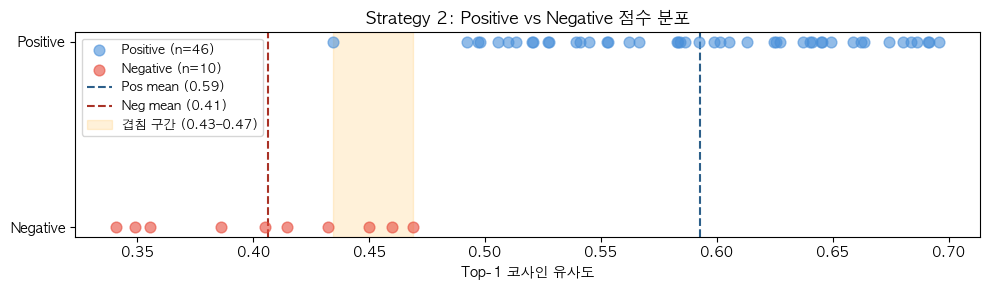

In [90]:
plt.figure(figsize=(10, 3))

# 스트립 플롯: 각 점수를 점으로 찍어 개별 분포 확인
plt.scatter(pos_scores, [1] * len(pos_scores), alpha=0.6, s=60, color="#4A90D9", label=f"Positive (n={len(pos_scores)})", zorder=3)
plt.scatter(neg_scores, [0] * len(neg_scores), alpha=0.6, s=60, color="#E74C3C", label=f"Negative (n={len(neg_scores)})", zorder=3)

# 평균선
plt.axvline(np.mean(pos_scores), color="#2C5F8A", linestyle="--", linewidth=1.5, label=f"Pos mean ({np.mean(pos_scores):.2f})")
plt.axvline(np.mean(neg_scores), color="#A93226", linestyle="--", linewidth=1.5, label=f"Neg mean ({np.mean(neg_scores):.2f})")

# 겹치는 구간: positive와 negative 점수가 동시에 존재하는 x축 범위
overlap_min = max(min(neg_scores), min(pos_scores))
overlap_max = min(max(neg_scores), max(pos_scores))
plt.axvspan(overlap_min, overlap_max, alpha=0.15, color="orange", label=f"겹침 구간 ({overlap_min:.2f}–{overlap_max:.2f})")

plt.xlabel("Top-1 코사인 유사도")
plt.yticks([0, 1], ["Negative", "Positive"])
plt.title("Strategy 2: Positive vs Negative 점수 분포")
plt.legend(fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

**결과 분석:**

| | Positive mean | Negative mean | Gap (차이) |
|--|--|--|--|
| Strategy 1 | 0.51 | 0.36 | 0.14 |
| Strategy 2 | **0.59** | 0.41 | **0.19** |

- **Gap 크게 증가**: 0.14 → 0.19. positive가 더 많이 올라 분리가 개선됨.
- **Positive min 대폭 개선**: 0.26 → 0.43. Strategy 1에서 negative 수준으로 낮았던 "도메인 연결" 질문(0.26)이 0.43으로 올라옴. 긴 문서에서 도메인 관련 문단이 별도 청크로 분리된 효과.
- **Negative max 억제**: 0.45 → 0.47. negative 점수는 소폭 증가에 그침.
- **분리 가능성**: negative max(0.47) < positive mean(0.59). 0.50 근처에 임계값을 설정하면 대부분의 positive/negative를 구분할 수 있음. Strategy 1(negative max 0.45 ≈ positive mean 0.51)에서는 불가능했던 수준.

#### d. 오답 분석 

점수가 낮은 질문을 확인하여 Strategy 1에서 miss됐던 질문이 개선되었는지 확인한다.

In [82]:
# URL → title 매핑
url_to_title = {doc["url"]: doc["title"] for doc in documents}

scored = []
for item in positive:
    results = search(item["question"], store_recursive, k=1)
    expected_url = item["relevant_doc_urls"][0]
    scored.append({
        "score": results[0]["score"],
        "question": item["question"],
        "expected": url_to_title.get(expected_url, expected_url),
        "got": results[0]["title"],
        "hit": results[0]["source_url"] in item["relevant_doc_urls"],
    })

scored.sort(key=lambda x: x["score"])

print("하위 10개 (점수 낮은 순)")
print("-" * 80)
for s in scored[:10]:
    marker = "O" if s["hit"] else "X"
    print(f"[{marker}] [{s['score']:.4f}] {s['question'][:45]}")
    print(f"         기대: {s['expected']} → 결과: {s['got']}")

하위 10개 (점수 낮은 순)
--------------------------------------------------------------------------------
[O] [0.4344] 도메인 연결 후 적용되기까지 시간이 얼마나 걸리나요?
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[O] [0.4921] 특정 고객한테만 따로 결제 링크 보내고 싶은데 어떻게 해?
         기대: 개인 결제창 생성하기 → 결과: 개인 결제창 생성하기
[O] [0.4969] 배송비 묶음 설정은 어디서 하나요?
         기대: 배송 방식 관리하기 → 결과: 배송 방식 관리하기
[O] [0.4978] 공통 정보 상세 설명 최대 글자 수
         기대: 공통 정보 관리 활용하기 → 결과: 공통 정보 관리 활용하기
[O] [0.5054] 등급 할인 혜택 정액과 정률 차이가 뭔가요?
         기대: 고객 등급 관리 → 결과: 고객 등급 관리
[O] [0.5098] 검색 엔진에 내 쇼핑몰 노출시키는 방법
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[O] [0.5132] 배송비 부과 유형 종류
         기대: 배송 방식 관리하기 → 결과: 배송 방식 관리하기
[O] [0.5200] 세부 품목 최대 개수
         기대: 옵션 관리하기 → 결과: 옵션 관리하기
[O] [0.5209] 개인 결제창 URL을 복사했는데 기본 도메인으로 나와요. 커스텀 도메인으로 바꿔서
         기대: 개인 결제창 생성하기 → 결과: 개인 결제창 생성하기
[O] [0.5273] 카테고리 최대 몇 차까지 만들 수 있어?
         기대: 카테고리 관리하기 → 결과: 카테고리 관리하기


**결과 분석:**

하위 10개가 **전부 정답(O)**이다. Strategy 1에서 miss됐던 3건이 모두 해결됨:

| 질문 | Strategy 1 | Strategy 2 |
|------|-----------|-----------|
| SKU 코드가 뭐야? | X (0.36) → 상품 추가하기 | O (정답 찾음) |
| 세부 품목 최대 개수 | X (0.37) → 상품 전시 방식 | O (0.52) → 옵션 관리하기 |
| PG 신청하면 결제 오픈까지 | X (0.37) → 개인 결제창 | O (정답 찾음) |

Strategy 1 분석에서 예측했던 대로, 긴 문서에서 특정 문단을 별도 청크로 분리하니 해당 질문이 정확히 매칭되었다.

단, k=1 Hit Rate가 0.913이므로 **4건의 miss가 존재**한다. 하위 10개에 miss가 없다는 것은, miss된 질문들의 점수가 상대적으로 높다는 뜻 — **"자신 있게 틀리는(confident but wrong)" 케이스**. 여러 문서의 청크가 비슷한 키워드를 포함할 때, 의미적으로 더 관련 있는 청크가 아닌 다른 문서의 청크가 1위를 차지하는 현상이다. 이는 페이지 단위의 "자신 없이 틀리는" 패턴과 대조적이다.

#### e. 핵심 인사이트

1. **k=1 Hit Rate 0.76 → 0.91 (+15%p)**: 청킹만으로 목표치(0.85~0.90) 초과 달성
2. **Strategy 1의 miss 3건 모두 해결**: 긴 문서의 벡터 희석 문제가 청킹으로 해소됨
3. **MAP 계산 버그 발견**: 청크 레벨에서는 같은 문서의 청크가 중복 hit되어 MAP > 1.0 → Hit Rate/MRR로 비교해야 함
4. **새로운 오류 패턴**: "자신 없이 틀리는" (low score + wrong) → "자신 있게 틀리는" (mid-high score + wrong)으로 변화. 헤딩 기반/시맨틱 청킹으로 개선 가능성 있음

## 7. Strategy 3: 헤딩 기반 분할

### 1) 청킹

In [98]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("###", "H3"),
    ("####", "H4"),
]

md_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on,
    strip_headers=False,  # 헤딩을 청크 텍스트에 포함 (임베딩 컨텍스트 유지)
)


def chunk_by_heading(documents):
    """마크다운 헤딩(H3/H4) 경계로 문서를 분할한다."""
    chunks = []
    for doc in documents:
        splits = md_splitter.split_text(doc["content"])
        for split in splits:
            text = split.page_content
            if text.strip():
                chunks.append({
                    "text": text,
                    "source_url": doc["url"],
                    "title": doc["title"],
                })
    return chunks


chunks_heading = chunk_by_heading(documents)

print(f"청크 수: {len(chunks_heading)} (문서 {len(documents)}개에서 분할)")
print()
for c in chunks_heading:
    preview = c["text"].replace("\n", " ")[:50]
    print(f"  [{len(c['text']):>4}자] {c['title'][:15]} | {preview}...")

청크 수: 73 (문서 10개에서 분할)

  [  95자] 쇼핑몰 빠른 시작 가이드 | 쇼핑몰 개설 준비와 운영에 도움이 되는 권장 설정까지, 이번 가이드에서 한번에 끝내 보세요...
  [ 259자] 쇼핑몰 빠른 시작 가이드 | ### 1. 기본 설정   #### 기본 정보 입력 식스샵 프로 계정에 로그인 후, 먼저 ...
  [ 549자] 쇼핑몰 빠른 시작 가이드 | #### 상품 등록/노출 쇼핑몰의 필수 요소인 상품을 등록하고, 상점에 노출하는 과정입니다...
  [ 209자] 쇼핑몰 빠른 시작 가이드 | #### 쇼핑몰 플랜 결제 상품 등록을 마쳤다면, 왼쪽 하단 [플랜 업그레이드] 버튼을 클...
  [ 415자] 쇼핑몰 빠른 시작 가이드 | #### PG 신청 상품을 구매하려는 고객이 ‘결제’할 수 있도록 PG(결제 서비스) 연동...
  [ 405자] 쇼핑몰 빠른 시작 가이드 | ### 2. 판매 준비   #### 디자인 편집 식스샵 프로가 제공하는 다양한 섹션들로 감...
  [ 241자] 쇼핑몰 빠른 시작 가이드 | #### 도메인 연결 구매해 둔 도메인이 있다면, 식스샵 프로 사이트와 연결할 수 있어요....
  [ 501자] 쇼핑몰 빠른 시작 가이드 | #### 간편결제 연동 구매자의 귀찮음을 줄이고 빠른 결제를 유도하는 방법, 바로 간편결제...
  [ 501자] 쇼핑몰 빠른 시작 가이드 | ### 3. 추가 권장 설정   #### 운영 알림 설정 다양한 상황에서 고객님과 운영자님...
  [ 201자] 쇼핑몰 빠른 시작 가이드 | #### 소셜 로그인 카카오/네이버 소셜 계정을 활용하여 3초 만에 자사몰 회원 가입을 유...
  [ 519자] 쇼핑몰 빠른 시작 가이드 | #### SEO 설정 쇼핑몰이 네이버/구글 검색 엔진에 더욱 원활히 노출될 수 있도록, 검...
  [ 544자] 쇼핑몰 빠른 시작 가이드 | #### 마케팅 세팅 쿠폰, 고객 세그먼트, 마케팅 메시지(친구톡) 등 식스샵 프로의 강력...
  [ 239자] 쇼핑몰 빠른

### 2) 임베딩 + 벡터 저장소

In [99]:
texts = [c["text"] for c in chunks_heading]
embeddings_heading = embed_texts(texts)

vector_stores["heading"] = {
    "chunks": chunks_heading,
    "embeddings": np.array(embeddings_heading),
}

print(f"벡터 저장소 구축 완료")
print(f"  청크 수: {len(chunks_heading)}")
print(f"  임베딩 shape: {vector_stores['heading']['embeddings'].shape}")

벡터 저장소 구축 완료
  청크 수: 73
  임베딩 shape: (73, 1536)


### 3) 평가

#### a. Positive 메트릭 계산

MAP은 청크 중복 hit으로 인해 1.0을 초과하므로 (Strategy 2에서 확인), Hit Rate와 MRR만 표시한다.

In [100]:
store_heading = vector_stores["heading"]
metrics_heading = evaluate(store_heading, positive, k_values=(1, 3, 5))

print("Strategy 3: MarkdownHeaderTextSplitter (H3/H4)")
print("=" * 55)
print(f"{'k':>3} | {'Hit Rate':>10} | {'MRR':>10}")
print("-" * 55)
for k, m in metrics_heading.items():
    print(f"{k:>3} | {m['hit_rate']:>10.4f} | {m['mrr']:>10.4f}")

# baseline & recursive 비교
print()
metrics_s1 = evaluate(vector_stores["page_level"], positive, k_values=(1, 3, 5))
metrics_s2 = evaluate(vector_stores["recursive"], positive, k_values=(1, 3, 5))
print("전략 간 Hit Rate 비교")
print("-" * 55)
for k in (1, 3, 5):
    print(f"  k={k}: S1 {metrics_s1[k]['hit_rate']:.4f} → S2 {metrics_s2[k]['hit_rate']:.4f} → S3 {metrics_heading[k]['hit_rate']:.4f}")

Strategy 3: MarkdownHeaderTextSplitter (H3/H4)
  k |   Hit Rate |        MRR
-------------------------------------------------------
  1 |     0.8696 |     0.8696
  3 |     0.9348 |     0.9022
  5 |     0.9565 |     0.9076

전략 간 Hit Rate 비교
-------------------------------------------------------
  k=1: S1 0.7609 → S2 0.9130 → S3 0.8696
  k=3: S1 0.9565 → S2 0.9783 → S3 0.9348
  k=5: S1 0.9783 → S2 1.0000 → S3 0.9565


**결과 분석:**

Strategy 2 대비 **전 구간에서 하락**:

| 지표 | Strategy 1 | Strategy 2 | Strategy 3 | S2→S3 |
|------|-----------|-----------|-----------|-------|
| k=1 Hit Rate | 0.761 | **0.913** | 0.870 | -0.043 |
| k=3 Hit Rate | 0.957 | **0.978** | 0.935 | -0.043 |
| k=5 Hit Rate | 0.978 | **1.000** | 0.957 | -0.043 |
| MRR@3 | 0.851 | **0.942** | 0.902 | -0.040 |

**왜 "의미 단위 분할"이 오히려 나빠졌는가:**

1. **청크 길이 불균형**: 73개 청크 중 100자 미만 짧은 청크가 다수. 임베딩 품질이 낮음. 전략 2는 1000자 단위로 균일하게 채워 문맥이 풍부.
2. **overlap 부재**: 전략 2는 `chunk_overlap=200`으로 경계 정보가 보존되지만, 헤딩 분할은 overlap이 없어 경계에서 정보가 끊김.
3. **질문-청크 granularity 불일치**: 여러 헤딩에 걸친 질문은 어느 한 청크에도 완전히 매칭되지 않음.

**핵심 인사이트**: "구조적으로 올바른 분할"이 반드시 "검색에 좋은 분할"은 아니다. 임베딩 모델에게는 적절한 길이와 문맥 밀도가 더 중요하다.

In [ ]:
lengths_s2 = [len(c["text"]) for c in chunks_recursive]
lengths_s3 = [len(c["text"]) for c in chunks_heading]
max_len = max(max(lengths_s2), max(lengths_s3))
bins = range(0, max_len + 100, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

ax1.hist(lengths_s2, bins=bins, weights=np.ones(len(lengths_s2)) / len(lengths_s2) * 100, color="#4A90D9", edgecolor="white", alpha=0.8)
ax1.axvline(np.mean(lengths_s2), color="#E74C3C", linestyle="--", linewidth=1.5, label=f"평균 {np.mean(lengths_s2):.0f}자")
ax1.axvline(np.median(lengths_s2), color="#2ECC71", linestyle="--", linewidth=1.5, label=f"중앙값 {np.median(lengths_s2):.0f}자")
ax1.set_xlabel("청크 길이 (자)")
ax1.set_ylabel("비율 (%)")
ax1.set_title(f"Strategy 2: Recursive ({len(lengths_s2)}개 | {min(lengths_s2)}~{max(lengths_s2)}자)")
ax1.legend(fontsize=8)

ax2.hist(lengths_s3, bins=bins, weights=np.ones(len(lengths_s3)) / len(lengths_s3) * 100, color="#E67E22", edgecolor="white", alpha=0.8)
ax2.axvline(np.mean(lengths_s3), color="#E74C3C", linestyle="--", linewidth=1.5, label=f"평균 {np.mean(lengths_s3):.0f}자")
ax2.axvline(np.median(lengths_s3), color="#2ECC71", linestyle="--", linewidth=1.5, label=f"중앙값 {np.median(lengths_s3):.0f}자")
ax2.set_xlabel("청크 길이 (자)")
ax2.set_title(f"Strategy 3: Heading ({len(lengths_s3)}개 | {min(lengths_s3)}~{max(lengths_s3)}자)")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

#### b. Negative 유사도 점수 확인

In [101]:
for item in negative:
    results = search(item["question"], store_heading, k=1)
    score = results[0]["score"]
    print(f"[{score:.4f}] {item['question'][:40]}... → {results[0]['title']}")

[0.4354] 고객이 주문 취소를 요청하는데 환불 처리는 어떻게 해야 하나요?... → 개인 결제창 생성하기
[0.4633] 주문 상태를 일괄 변경하는 방법이 있나요?... → 옵션 관리하기
[0.4962] 쇼핑몰 디자인 테마 변경 어떻게 해?... → 쇼핑몰 빠른 시작 가이드
[0.3974] 다국어 설정 영어 일본어 지원... → 상품 추가하기
[0.4048] 세금계산서 자동 발행 설정 방법... → 고객 등급 관리
[0.3593] 회원 탈퇴 처리 어떻게 해?... → 쇼핑몰 빠른 시작 가이드
[0.3852] 매출 통계 리포트 확인 방법... → 상품 추가하기
[0.3954] 고객 문의 게시판 답변은 어디서 하나요?... → 쇼핑몰 빠른 시작 가이드
[0.5336] 적립금 자동 지급 설정... → 고객 등급 관리
[0.3783] 상품 리뷰에 악성 댓글이 달렸는데 삭제하거나 숨길 수 있어?... → 상품 추가하기


**결과 분석:**

negative 질문은 FAQ에 답이 없는 질문이므로, **점수가 낮을수록 좋다** (= "답이 없다"고 올바르게 판별 가능). 3전략 전체 비교:

| 질문 | S1 | S2 | S3 | 추세 |
|------|-----|-----|-----|------|
| 주문 취소/환불 | 0.442 | 0.450 | 0.435 | ↓ 개선 |
| 주문 상태 일괄 변경 | 0.450 | 0.460 | 0.463 | ↑ 악화 |
| 디자인 테마 변경 | 0.389 | 0.469 | 0.496 | ↑ 악화 |
| 다국어 설정 | 0.248 | 0.341 | 0.397 | ↑ 악화 |
| 세금계산서 자동 발행 | 0.360 | 0.405 | 0.405 | → 유지 |
| 회원 탈퇴 | 0.298 | 0.349 | 0.359 | ↑ 악화 |
| 매출 통계 리포트 | 0.359 | 0.356 | 0.385 | ↑ 악화 |
| 고객 문의 게시판 | 0.384 | 0.415 | 0.395 | ↓ 개선 |
| 적립금 자동 지급 | 0.346 | 0.432 | **0.534** | ↑↑ 크게 악화 |
| 상품 리뷰 악성 댓글 | 0.356 | 0.386 | 0.378 | ↓ 소폭 개선 |
| **mean** | **0.363** | **0.406** | **0.425** | ↑ 악화 |
| **max** | **0.450** | **0.469** | **0.534** | ↑ 악화 |

전략이 진행될수록 negative mean/max가 꾸준히 올라가고 있다. 특히 "적립금 자동 지급"(0.534)은 positive 하위권과 겹치는 수준이다.

#### c. Positive vs Negative 점수 분포 비교

In [102]:
# positive 질문들의 top-1 유사도 점수
pos_scores = []
for item in positive:
    results = search(item["question"], store_heading, k=1)
    pos_scores.append(results[0]["score"])

# negative 질문들의 top-1 유사도 점수
neg_scores = []
for item in negative:
    results = search(item["question"], store_heading, k=1)
    neg_scores.append(results[0]["score"])

print(f"positive top-1 score: min={min(pos_scores):.4f}, mean={np.mean(pos_scores):.4f}, max={max(pos_scores):.4f}")
print(f"negative top-1 score: min={min(neg_scores):.4f}, mean={np.mean(neg_scores):.4f}, max={max(neg_scores):.4f}")

positive top-1 score: min=0.4279, mean=0.5942, max=0.7359
negative top-1 score: min=0.3593, mean=0.4249, max=0.5336


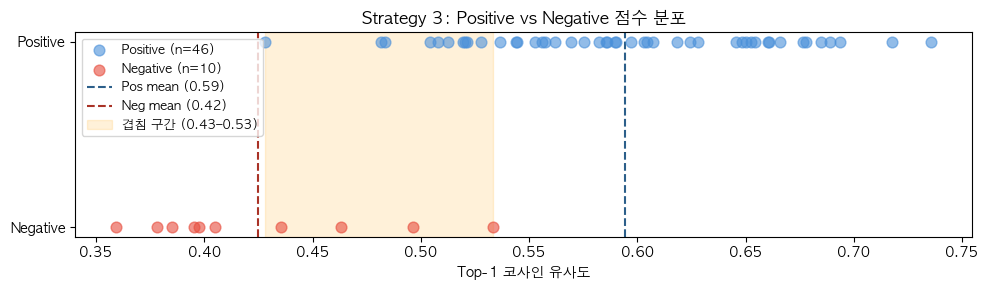

In [103]:
plt.figure(figsize=(10, 3))

plt.scatter(pos_scores, [1] * len(pos_scores), alpha=0.6, s=60, color="#4A90D9", label=f"Positive (n={len(pos_scores)})", zorder=3)
plt.scatter(neg_scores, [0] * len(neg_scores), alpha=0.6, s=60, color="#E74C3C", label=f"Negative (n={len(neg_scores)})", zorder=3)

plt.axvline(np.mean(pos_scores), color="#2C5F8A", linestyle="--", linewidth=1.5, label=f"Pos mean ({np.mean(pos_scores):.2f})")
plt.axvline(np.mean(neg_scores), color="#A93226", linestyle="--", linewidth=1.5, label=f"Neg mean ({np.mean(neg_scores):.2f})")

overlap_min = max(min(neg_scores), min(pos_scores))
overlap_max = min(max(neg_scores), max(pos_scores))
if overlap_min < overlap_max:
    plt.axvspan(overlap_min, overlap_max, alpha=0.15, color="orange", label=f"겹침 구간 ({overlap_min:.2f}–{overlap_max:.2f})")

plt.xlabel("Top-1 코사인 유사도")
plt.yticks([0, 1], ["Negative", "Positive"])
plt.title("Strategy 3: Positive vs Negative 점수 분포")
plt.legend(fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

**결과 분석:**

| | Positive mean | Negative mean | Gap | Positive min | Negative max |
|--|--|--|--|--|--|
| Strategy 1 | 0.51 | 0.36 | 0.14 | 0.26 | 0.45 |
| Strategy 2 | **0.59** | 0.41 | **0.19** | **0.43** | 0.47 |
| Strategy 3 | 0.59 | 0.42 | 0.17 | 0.43 | **0.53** |

- **Positive mean은 전략 2와 동일**(0.59). 청크 방식이 달라도 positive 평균 유사도는 비슷.
- **Negative max가 0.47→0.53으로 악화**: 짧은 청크가 키워드 매칭에 민감해져 negative도 높은 점수를 받음.
- **Gap 축소**: 0.19→0.17. 두 분포의 분리도가 전략 2보다 후퇴.
- **임계값 설정 난이도 상승**: 겹침 구간이 넓어져 "답이 있다/없다" 판별이 더 어려움.

#### d. 오답 분석

In [104]:
# URL → title 매핑
url_to_title = {doc["url"]: doc["title"] for doc in documents}

scored = []
for item in positive:
    results = search(item["question"], store_heading, k=1)
    expected_url = item["relevant_doc_urls"][0]
    scored.append({
        "score": results[0]["score"],
        "question": item["question"],
        "expected": url_to_title.get(expected_url, expected_url),
        "got": results[0]["title"],
        "hit": results[0]["source_url"] in item["relevant_doc_urls"],
    })

scored.sort(key=lambda x: x["score"])

print("하위 10개 (점수 낮은 순)")
print("-" * 80)
for s in scored[:10]:
    marker = "O" if s["hit"] else "X"
    print(f"[{marker}] [{s['score']:.4f}] {s['question'][:45]}")
    print(f"         기대: {s['expected']} → 결과: {s['got']}")

하위 10개 (점수 낮은 순)
--------------------------------------------------------------------------------
[O] [0.4279] 등급 할인 혜택 정액과 정률 차이가 뭔가요?
         기대: 고객 등급 관리 → 결과: 고객 등급 관리
[X] [0.4818] 추가 적립금 기능을 쓰려면 미리 설정해둬야 하는 게 있나요?
         기대: 고객 등급 관리 → 결과: 옵션 관리하기
[X] [0.4837] 개인 결제창 상품 카테고리를 왜 미분류로 해야 하나요?
         기대: 개인 결제창 생성하기 → 결과: 상품 추가하기
[X] [0.5042] 특정 고객한테만 따로 결제 링크 보내고 싶은데 어떻게 해?
         기대: 개인 결제창 생성하기 → 결과: 상품 추가하기
[O] [0.5082] 재고 수량을 한꺼번에 바꿨는데 일부만 실패했어. 실패한 항목은 어디서 확인해?
         기대: 재고 관리하기 → 결과: 재고 관리하기
[X] [0.5128] 등급 이름 최대 몇 자까지 설정 가능해?
         기대: 고객 등급 관리 → 결과: 상품 추가하기
[O] [0.5193] 카테고리 최대 몇 차까지 만들 수 있어?
         기대: 카테고리 관리하기 → 결과: 카테고리 관리하기
[O] [0.5202] PG 신청하면 결제 오픈까지 얼마나 걸려?
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[O] [0.5211] 고객이 연결되어 있는 등급을 삭제하고 싶은데 바로 삭제가 안 돼요. 어떻게 해야 
         기대: 고객 등급 관리 → 결과: 고객 등급 관리
[O] [0.5280] 세부 품목 최대 개수
         기대: 옵션 관리하기 → 결과: 옵션 관리하기


**결과 분석:**

하위 10개 중 miss가 **4건**(Strategy 2는 0건이었음). 패턴이 뚜렷하다:

| 질문 | 기대 문서 | 매칭 문서 | 원인 |
|------|----------|----------|------|
| 추가 적립금 미리 설정 | 고객 등급 관리 | 옵션 관리하기 | "등급 관리" 청크가 짧아 "적립금" 키워드 신호 약함 |
| 개인 결제창 카테고리 미분류 | 개인 결제창 생성하기 | 상품 추가하기 | "상품 추가하기"에 카테고리 청크가 많아 흡수 |
| 특정 고객 결제 링크 | 개인 결제창 생성하기 | 상품 추가하기 | 동일 원인 — "상품 추가하기" 38개 청크 vs "개인 결제창" 1개 청크 |
| 등급 이름 최대 몇 자 | 고객 등급 관리 | 상품 추가하기 | 짧은 세부 질문이 "상품 추가하기"의 다수 청크에 끌림 |

**핵심 문제: 문서 간 청크 수 불균형**
- "상품 추가하기": **20개 청크** (H4가 많은 긴 문서)
- "개인 결제창 생성하기": **1개 청크** (헤딩이 거의 없는 문서)
- 청크가 많은 문서가 검색에서 유리해지는 구조적 편향 발생

Strategy 2에서는 1000자 단위로 균일하게 나눠져 이 편향이 적었다.

### 핵심 인사이트

**"구조적으로 올바른 분할 ≠ 검색에 좋은 분할"**

헤딩 기반 분할은 사람이 읽기에 논리적인 단위지만, 임베딩 검색에는 오히려 불리했다:

1. **청크 길이 균일성이 중요하다**: 짧은 청크(21~100자)는 임베딩 품질이 낮고, 긴 청크(1000자+)는 신호가 희석된다. 전략 2의 고정 길이(500자)가 더 안정적인 성능을 보임.
2. **overlap은 공짜 성능이다**: 전략 2의 `chunk_overlap=200`은 경계 정보를 보존해 hit rate를 높였다. 헤딩 분할에는 이 메커니즘이 없다.
3. **문서 간 청크 수 불균형은 검색 편향을 만든다**: "상품 추가하기"(20청크) vs "개인 결제창"(1청크) — 청크가 많은 문서가 검색에서 구조적으로 유리해진다.
4. **negative 점수도 함께 봐야 한다**: positive만 보면 S2(0.59)와 S3(0.59)가 동일하지만, negative max가 0.47→0.53으로 올라 분리도가 악화됐다.

**결론**: 전략 2(RecursiveCharacterTextSplitter)가 현재까지 최선. 전략 4(Semantic Chunking)에서는 의미 단위 + 길이 균일성을 동시에 잡을 수 있는지 확인한다.

## 8. Strategy 4: Semantic Chunking

### 1) 청킹

SemanticChunker는 문장을 순서대로 임베딩한 뒤, **인접 문장 간 유사도가 급격히 떨어지는 지점**에서 분할한다.
- `breakpoint_threshold_type="percentile"`: 유사도 변화량(distance)의 상위 N%(기본 95%)를 분할점으로 사용
- 전략 2(고정 길이)와 달리 **의미가 전환되는 자연스러운 경계**에서 나눔
- 전략 3(헤딩 기반)과 달리 **문서 구조에 의존하지 않음** — 헤딩이 없는 문서에도 동작

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings

# SemanticChunker는 자체 임베딩 모델이 필요 (분할 시점 판단용)
embeddings_model = OpenAIEmbeddings(model=EMBEDDING_MODEL)

semantic_chunker = SemanticChunker(
    embeddings=embeddings_model,
    breakpoint_threshold_type="percentile",  # 유사도 변화량의 상위 N%를 분할점으로
)


def chunk_semantically(documents):
    """문장 간 임베딩 유사도 변곡점에서 분할한다."""
    chunks = []
    for doc in documents:
        splits = semantic_chunker.split_text(doc["content"])
        for text in splits:
            if text.strip():
                chunks.append({
                    "text": text,
                    "source_url": doc["url"],
                    "title": doc["title"],
                })
    return chunks


chunks_semantic = chunk_semantically(documents)

print(f"청크 수: {len(chunks_semantic)} (문서 {len(documents)}개에서 분할)")
print()
for c in chunks_semantic:
    preview = c["text"].replace("\n", " ")[:50]
    print(f"  [{len(c['text']):>4}자] {c['title'][:15]} | {preview}...")

청크 수: 34 (문서 10개에서 분할)

  [ 102자] 쇼핑몰 빠른 시작 가이드 | 쇼핑몰 개설 준비와 운영에 도움이 되는 권장 설정까지, 이번 가이드에서 한번에 끝내 보세요...
  [1361자] 쇼핑몰 빠른 시작 가이드 | 기본 설정 #### 기본 정보 입력 식스샵 프로 계정에 로그인 후, 먼저 [설정 > 스토어...
  [ 954자] 쇼핑몰 빠른 시작 가이드 | TIP! 디자인은 심사 요소가 아니기 때문에, 우선 PG부터 신청하고 디자인을 해 주시는 ...
  [ 144자] 쇼핑몰 빠른 시작 가이드 | 주문형/결제형을 모두 이용하시려면 주문형 → 결제형 순으로 진행해 주셔야 정산 주기 협의에...
  [2091자] 쇼핑몰 빠른 시작 가이드 | 전화 문의: 1544-7772 채팅 상담: [https://www.tosspayments....
  [ 956자] 고객 등급 관리 | #### 등급 추가하기 [식스샵 프로 > 고객 관리 > 등급]의 우측 상단 등급 추가하기로...
  [   3자] 고객 등급 관리 | Q1....
  [ 250자] 고객 등급 관리 | 고객은 자신의 등급과 혜택을 어디서 볼 수 있나요? 마이페이지와 상품 목록/상품 상세 페이...
  [ 512자] 상품 추가하기 | 설정 목차를 활용하면 원하는 항목으로 빠르게 이동하며 등록할 정보만 선택해 상품 등록을 더...
  [1000자] 상품 추가하기 | 상품 관리 코드 상품 관리 용이성을 위해 상품마다 부여하는 코드입니다. 하위 주소 상품 고...
  [2130자] 상품 추가하기 | 이미지 추가  파일명에 괄호 - (,)가 포함되면 이미지가 정상 노출되지 않을 수 있으니 ...
  [1102자] 상품 추가하기 | #### 제조 정보 상품의 제조 정보를 입력해 주세요. 원산지 선택 시 아래 사항을 참고해...
  [   3자] 상품 추가하기 | Q1....
  [ 314자] 상품 추가하기 | 상품을 추가했는데 웹사이트에서 상품이 보이지 않아요! 상품 노출하기 과정이 필요해요. [웹...
 

### 2) 임베딩 + 벡터 저장소

In [114]:
texts = [c["text"] for c in chunks_semantic]
embeddings_semantic = embed_texts(texts)

vector_stores["semantic"] = {
    "chunks": chunks_semantic,
    "embeddings": np.array(embeddings_semantic),
}

print(f"벡터 저장소 구축 완료")
print(f"  청크 수: {len(chunks_semantic)}")
print(f"  임베딩 shape: {vector_stores['semantic']['embeddings'].shape}")

벡터 저장소 구축 완료
  청크 수: 34
  임베딩 shape: (34, 1536)


### 3) 평가

#### a. Positive 메트릭 계산

MAP은 청크 중복 hit으로 인해 1.0을 초과하므로 (Strategy 2에서 확인), Hit Rate과 MRR만 비교한다.

In [115]:
store_semantic = vector_stores["semantic"]
metrics_semantic = evaluate(store_semantic, positive, k_values=(1, 3, 5))

print("Strategy 4: SemanticChunker (percentile)")
print("=" * 55)
print(f"{'k':>3} | {'Hit Rate':>10} | {'MRR':>10}")
print("-" * 55)
for k, m in metrics_semantic.items():
    print(f"{k:>3} | {m['hit_rate']:>10.4f} | {m['mrr']:>10.4f}")

# 4전략 비교
print()
metrics_s1 = evaluate(vector_stores["page_level"], positive, k_values=(1, 3, 5))
metrics_s2 = evaluate(vector_stores["recursive"], positive, k_values=(1, 3, 5))
metrics_s3 = evaluate(vector_stores["heading"], positive, k_values=(1, 3, 5))
print("전략 간 Hit Rate 비교")
print("-" * 55)
for k in (1, 3, 5):
    print(f"  k={k}: S1 {metrics_s1[k]['hit_rate']:.4f} → S2 {metrics_s2[k]['hit_rate']:.4f} → S3 {metrics_s3[k]['hit_rate']:.4f} → S4 {metrics_semantic[k]['hit_rate']:.4f}")

Strategy 4: SemanticChunker (percentile)
  k |   Hit Rate |        MRR
-------------------------------------------------------
  1 |     0.8696 |     0.8696
  3 |     0.9565 |     0.9058
  5 |     0.9783 |     0.9101

전략 간 Hit Rate 비교
-------------------------------------------------------
  k=1: S1 0.7609 → S2 0.9130 → S3 0.8696 → S4 0.8696
  k=3: S1 0.9565 → S2 0.9783 → S3 0.9348 → S4 0.9565
  k=5: S1 0.9783 → S2 1.0000 → S3 0.9565 → S4 0.9783


**결과 분석:**

| 지표 | S1 | S2 | S3 | S4 | 최고 |
|------|-----|-----|-----|-----|:----:|
| k=1 Hit Rate | 0.761 | **0.913** | 0.870 | 0.870 | S2 |
| k=3 Hit Rate | 0.957 | **0.978** | 0.935 | 0.957 | S2 |
| k=5 Hit Rate | 0.978 | **1.000** | 0.957 | 0.978 | S2 |
| MRR@1 | 0.761 | **0.913** | 0.870 | 0.870 | S2 |
| MRR@3 | 0.851 | **0.942** | 0.902 | 0.906 | S2 |

- **S3와 동일한 k=1 Hit Rate** (0.870): 의미 기반 분할도 S2를 넘지 못함.
- **k=3, k=5에서 S3 대비 개선**: 청크 수가 34개(S3의 73개 절반)로 적어 k=5 내에 더 다양한 문서가 포함됨.
- **청크 수 34개**: S2(67개), S3(73개)의 절반. 의미 변곡점이 적어 큰 덩어리로 남는 경향.

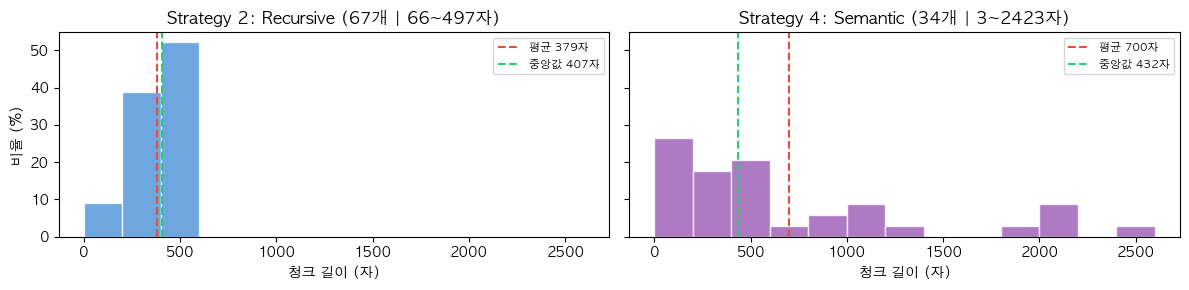

In [122]:
lengths_s2 = [len(c["text"]) for c in chunks_recursive]
lengths_s4 = [len(c["text"]) for c in chunks_semantic]
max_len = max(max(lengths_s2), max(lengths_s4))
bins = range(0, max_len + 200, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

ax1.hist(lengths_s2, bins=bins, weights=np.ones(len(lengths_s2)) / len(lengths_s2) * 100, color="#4A90D9", edgecolor="white", alpha=0.8)
ax1.axvline(np.mean(lengths_s2), color="#E74C3C", linestyle="--", linewidth=1.5, label=f"평균 {np.mean(lengths_s2):.0f}자")
ax1.axvline(np.median(lengths_s2), color="#2ECC71", linestyle="--", linewidth=1.5, label=f"중앙값 {np.median(lengths_s2):.0f}자")
ax1.set_xlabel("청크 길이 (자)")
ax1.set_ylabel("비율 (%)")
ax1.set_title(f"Strategy 2: Recursive ({len(lengths_s2)}개 | {min(lengths_s2)}~{max(lengths_s2)}자)")
ax1.legend(fontsize=8)

ax2.hist(lengths_s4, bins=bins, weights=np.ones(len(lengths_s4)) / len(lengths_s4) * 100, color="#9B59B6", edgecolor="white", alpha=0.8)
ax2.axvline(np.mean(lengths_s4), color="#E74C3C", linestyle="--", linewidth=1.5, label=f"평균 {np.mean(lengths_s4):.0f}자")
ax2.axvline(np.median(lengths_s4), color="#2ECC71", linestyle="--", linewidth=1.5, label=f"중앙값 {np.median(lengths_s4):.0f}자")
ax2.set_xlabel("청크 길이 (자)")
ax2.set_title(f"Strategy 4: Semantic ({len(lengths_s4)}개 | {min(lengths_s4)}~{max(lengths_s4)}자)")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

#### b. Negative 유사도 점수 확인

In [116]:
for item in negative:
    results = search(item["question"], store_semantic, k=1)
    score = results[0]["score"]
    print(f"[{score:.4f}] {item['question'][:40]}... → {results[0]['title']}")

[0.4981] 고객이 주문 취소를 요청하는데 환불 처리는 어떻게 해야 하나요?... → 쇼핑몰 빠른 시작 가이드
[0.4695] 주문 상태를 일괄 변경하는 방법이 있나요?... → 상품 전시 방식 설정하기
[0.4774] 쇼핑몰 디자인 테마 변경 어떻게 해?... → 쇼핑몰 빠른 시작 가이드
[0.2800] 다국어 설정 영어 일본어 지원... → 고객 등급 관리
[0.3781] 세금계산서 자동 발행 설정 방법... → 상품 전시 방식 설정하기
[0.3340] 회원 탈퇴 처리 어떻게 해?... → 쇼핑몰 빠른 시작 가이드
[0.3681] 매출 통계 리포트 확인 방법... → 쇼핑몰 빠른 시작 가이드
[0.4033] 고객 문의 게시판 답변은 어디서 하나요?... → 쇼핑몰 빠른 시작 가이드
[0.4065] 적립금 자동 지급 설정... → 고객 등급 관리
[0.3656] 상품 리뷰에 악성 댓글이 달렸는데 삭제하거나 숨길 수 있어?... → 쇼핑몰 빠른 시작 가이드


**결과 분석:**

| 질문 | S1 | S2 | S3 | S4 | 추세 |
|------|-----|-----|-----|-----|------|
| 주문 취소/환불 | 0.442 | 0.450 | 0.435 | **0.498** | ↑ 악화 |
| 주문 상태 일괄 변경 | 0.450 | 0.460 | 0.463 | **0.470** | ↑ 악화 |
| 디자인 테마 변경 | 0.389 | 0.469 | 0.496 | **0.477** | ↓ S3 대비 개선 |
| 다국어 설정 | 0.248 | 0.341 | 0.397 | **0.280** | ↓ 크게 개선 |
| 세금계산서 자동 발행 | 0.360 | 0.405 | 0.405 | **0.378** | ↓ 개선 |
| 회원 탈퇴 | 0.298 | 0.349 | 0.359 | **0.334** | ↓ 개선 |
| 매출 통계 리포트 | 0.359 | 0.356 | 0.385 | **0.368** | ↓ S3 대비 개선 |
| 고객 문의 게시판 | 0.384 | 0.415 | 0.395 | **0.403** | → 비슷 |
| 적립금 자동 지급 | 0.346 | 0.432 | **0.534** | **0.407** | ↓ 크게 개선 |
| 상품 리뷰 악성 댓글 | 0.356 | 0.386 | 0.378 | **0.366** | ↓ 개선 |
| **mean** | **0.363** | **0.406** | **0.425** | **0.398** | ↓ S2 수준 복귀 |
| **max** | **0.450** | **0.469** | **0.534** | **0.498** | ↓ S3 대비 개선 |

Strategy 3의 핵심 문제였던 negative 악화가 상당히 완화됨. 특히 "적립금 자동 지급"이 0.534→0.407로 복귀. 청크가 커지면서 짧은 청크의 키워드 과민 반응이 줄어든 효과.

#### c. Positive vs Negative 점수 분포 비교

In [117]:
# positive 질문들의 top-1 유사도 점수
pos_scores = []
for item in positive:
    results = search(item["question"], store_semantic, k=1)
    pos_scores.append(results[0]["score"])

# negative 질문들의 top-1 유사도 점수
neg_scores = []
for item in negative:
    results = search(item["question"], store_semantic, k=1)
    neg_scores.append(results[0]["score"])

print(f"positive top-1 score: min={min(pos_scores):.4f}, mean={np.mean(pos_scores):.4f}, max={max(pos_scores):.4f}")
print(f"negative top-1 score: min={min(neg_scores):.4f}, mean={np.mean(neg_scores):.4f}, max={max(neg_scores):.4f}")

positive top-1 score: min=0.3400, mean=0.5720, max=0.8075
negative top-1 score: min=0.2800, mean=0.3981, max=0.4981


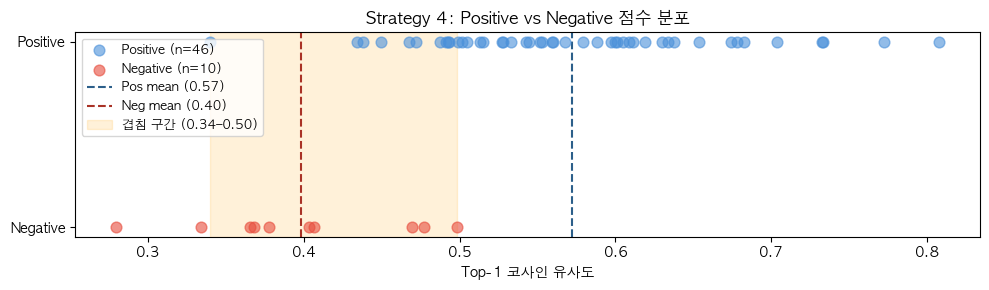

In [118]:
plt.figure(figsize=(10, 3))

plt.scatter(pos_scores, [1] * len(pos_scores), alpha=0.6, s=60, color="#4A90D9", label=f"Positive (n={len(pos_scores)})", zorder=3)
plt.scatter(neg_scores, [0] * len(neg_scores), alpha=0.6, s=60, color="#E74C3C", label=f"Negative (n={len(neg_scores)})", zorder=3)

plt.axvline(np.mean(pos_scores), color="#2C5F8A", linestyle="--", linewidth=1.5, label=f"Pos mean ({np.mean(pos_scores):.2f})")
plt.axvline(np.mean(neg_scores), color="#A93226", linestyle="--", linewidth=1.5, label=f"Neg mean ({np.mean(neg_scores):.2f})")

overlap_min = max(min(neg_scores), min(pos_scores))
overlap_max = min(max(neg_scores), max(pos_scores))
if overlap_min < overlap_max:
    plt.axvspan(overlap_min, overlap_max, alpha=0.15, color="orange", label=f"겹침 구간 ({overlap_min:.2f}–{overlap_max:.2f})")

plt.xlabel("Top-1 코사인 유사도")
plt.yticks([0, 1], ["Negative", "Positive"])
plt.title("Strategy 4: Positive vs Negative 점수 분포")
plt.legend(fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

**결과 분석:**

| | Positive mean | Negative mean | Gap | Positive min | Negative max |
|--|--|--|--|--|--|
| Strategy 1 | 0.51 | 0.36 | 0.14 | 0.26 | 0.45 |
| Strategy 2 | 0.59 | 0.41 | **0.19** | **0.43** | 0.47 |
| Strategy 3 | 0.59 | 0.42 | 0.17 | 0.43 | **0.53** |
| Strategy 4 | 0.57 | **0.40** | 0.17 | 0.34 | 0.50 |

- **Positive mean 소폭 하락** (0.59→0.57): 대형 청크(2000자+)에서 신호 희석 발생.
- **Negative mean 개선** (0.42→0.40): Strategy 3보다 negative를 잘 억제. 특히 "적립금 자동 지급"이 0.534→0.407로 크게 개선.
- **Positive min 하락** (0.43→0.34): "도메인 연결" 질문이 대형 청크에 묻혀 낮은 점수.
- **Gap은 S3와 동일** (0.17): S2(0.19)보다 여전히 작음.

#### d. 오답 분석

In [119]:
# URL → title 매핑
url_to_title = {doc["url"]: doc["title"] for doc in documents}

scored = []
for item in positive:
    results = search(item["question"], store_semantic, k=1)
    expected_url = item["relevant_doc_urls"][0]
    scored.append({
        "score": results[0]["score"],
        "question": item["question"],
        "expected": url_to_title.get(expected_url, expected_url),
        "got": results[0]["title"],
        "hit": results[0]["source_url"] in item["relevant_doc_urls"],
    })

scored.sort(key=lambda x: x["score"])

print("하위 10개 (점수 낮은 순)")
print("-" * 80)
for s in scored[:10]:
    marker = "O" if s["hit"] else "X"
    print(f"[{marker}] [{s['score']:.4f}] {s['question'][:45]}")
    print(f"         기대: {s['expected']} → 결과: {s['got']}")

하위 10개 (점수 낮은 순)
--------------------------------------------------------------------------------
[O] [0.3400] 도메인 연결 후 적용되기까지 시간이 얼마나 걸리나요?
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[O] [0.4341] 공통 정보 상세 설명 최대 글자 수
         기대: 공통 정보 관리 활용하기 → 결과: 공통 정보 관리 활용하기
[O] [0.4381] PG 신청하면 결제 오픈까지 얼마나 걸려?
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 쇼핑몰 빠른 시작 가이드
[X] [0.4499] 검색 엔진에 내 쇼핑몰 노출시키는 방법
         기대: 쇼핑몰 빠른 시작 가이드 → 결과: 상품 추가하기
[O] [0.4674] SKU 코드가 뭐야?
         기대: 재고 관리하기 → 결과: 재고 관리하기
[O] [0.4721] 배송비 묶음 설정은 어디서 하나요?
         기대: 배송 방식 관리하기 → 결과: 배송 방식 관리하기
[O] [0.4877] 특정 고객한테만 따로 결제 링크 보내고 싶은데 어떻게 해?
         기대: 개인 결제창 생성하기 → 결과: 개인 결제창 생성하기
[O] [0.4911] 등급 이름 최대 몇 자까지 설정 가능해?
         기대: 고객 등급 관리 → 결과: 고객 등급 관리
[O] [0.4927] 각인 문구처럼 구매자가 직접 텍스트를 입력하는 옵션은 어떻게 만들어?
         기대: 옵션 관리하기 → 결과: 옵션 관리하기
[O] [0.4934] 카테고리 최대 몇 차까지 만들 수 있어?
         기대: 카테고리 관리하기 → 결과: 카테고리 관리하기


**결과 분석:**

하위 10개 중 miss가 **1건**뿐 (Strategy 2: 0건, Strategy 3: 4건):

| 질문 | S2 | S3 | S4 | 변화 |
|------|:--:|:--:|:--:|------|
| 검색 엔진에 내 쇼핑몰 노출 | O | O | **X** | SEO 설명이 2091자 대형 청크에 묻힘 |
| 특정 고객 결제 링크 | O | X | **O** | 개인 결제창이 별도 청크(499자)로 분리됨 |
| 등급 이름 최대 몇 자 | O | X | **O** | 고객 등급 관리가 956자 청크에 포함 |

Strategy 3에서 miss됐던 3건 중 2건이 복구됨. 의미 기반 분할이 "개인 결제창" 같은 헤딩 없는 문서를 더 적절한 크기로 잘라준 효과.

**"검색 엔진 노출" miss 원인 — SemanticChunker의 구조적 한계:**
"쇼핑몰 빠른 시작 가이드"에는 기본 설정, PG 신청, 디자인, 도메인, SEO 등 12개 소주제가 있지만, SemanticChunker가 이를 나누지 못하고 2091자 청크로 남겼다. 이유는 `percentile` 임계값 방식에 있다:
- SemanticChunker는 인접 문장 간 거리의 **상위 5%만 분할점으로 선택**
- 이 문서의 소주제들은 모두 "쇼핑몰 초기 세팅"이라는 큰 맥락 안에서 **점진적으로 전환**됨 (기본 설정 → PG → 디자인 → 도메인 → ...)
- 소주제 간 의미 차이가 상위 5% 임계값을 넘지 못해 분할되지 않음
- 임계값을 낮추면(예: 80th percentile) 이 문서는 잘 나뉘겠지만, 다른 문서에서는 과도하게 쪼개질 수 있어 **문서별 최적 임계값이 다르다는 근본 문제**가 있음

### 핵심 인사이트

**SemanticChunker는 "똑똑한 분할"이지만 길이 제어가 안 된다**

1. **청크 수 절반** (34개 vs S2 67개, S3 73개): 의미 변곡점이 적은 문서는 거대한 청크(2000자+)로 남아, S1과 유사한 "신호 희석" 문제가 재발.
2. **Negative 억제에서 강점**: S3의 핵심 문제였던 짧은 청크의 키워드 과민 반응(적립금 0.534)이 0.407로 개선. 청크가 커지면 임베딩이 더 구체적인 방향을 가짐.
3. **길이 불균형은 S3보다 심각**: 3자~2423자 범위. S3(21~1154자)보다 편차가 크고, S2(균일 500자)와는 비교 불가.
4. **분할점 제어 한계**: `percentile` 임계값을 낮추면 청크가 작아지지만, 최적값을 찾는 별도 튜닝이 필요하고 문서마다 달라질 수 있음.

**결론**: S4는 S3의 negative 문제를 해결했지만, 대형 청크 문제로 positive에서 S2를 넘지 못함. **S2(RecursiveCharacterTextSplitter)가 여전히 종합 최고 전략**.

## 9. 전략 간 비교

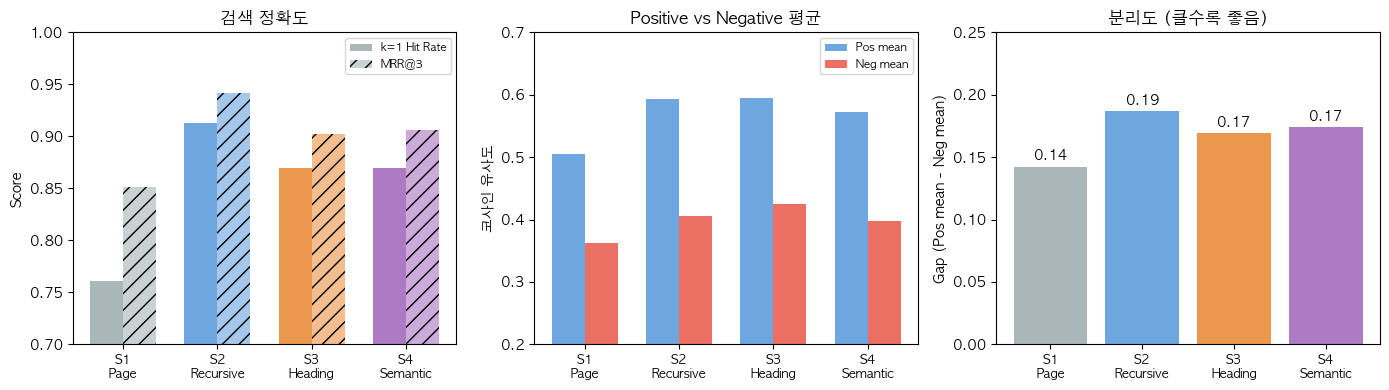

In [121]:
# 4전략 종합 비교 차트
strategies = ["S1\nPage", "S2\nRecursive", "S3\nHeading", "S4\nSemantic"]
colors = ["#95A5A6", "#4A90D9", "#E67E22", "#9B59B6"]

stores = [
    vector_stores["page_level"],
    vector_stores["recursive"],
    vector_stores["heading"],
    vector_stores["semantic"],
]

# 메트릭 수집
hit_rates_k1 = []
mrr_k3 = []
pos_means = []
neg_means = []
gaps = []

for store in stores:
    m = evaluate(store, positive, k_values=(1, 3))
    hit_rates_k1.append(m[1]["hit_rate"])
    mrr_k3.append(m[3]["mrr"])

    ps, ns = [], []
    for item in positive:
        r = search(item["question"], store, k=1)
        ps.append(r[0]["score"])
    for item in negative:
        r = search(item["question"], store, k=1)
        ns.append(r[0]["score"])
    pos_means.append(np.mean(ps))
    neg_means.append(np.mean(ns))
    gaps.append(np.mean(ps) - np.mean(ns))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1) Hit Rate & MRR
x = np.arange(len(strategies))
w = 0.35
axes[0].bar(x - w/2, hit_rates_k1, w, color=colors, alpha=0.8, label="k=1 Hit Rate")
axes[0].bar(x + w/2, mrr_k3, w, color=colors, alpha=0.5, label="MRR@3", hatch="//")
axes[0].set_xticks(x)
axes[0].set_xticklabels(strategies, fontsize=9)
axes[0].set_ylim(0.7, 1.0)
axes[0].set_ylabel("Score")
axes[0].set_title("검색 정확도")
axes[0].legend(fontsize=8)

# 2) Positive vs Negative mean
axes[1].bar(x - w/2, pos_means, w, color="#4A90D9", alpha=0.8, label="Pos mean")
axes[1].bar(x + w/2, neg_means, w, color="#E74C3C", alpha=0.8, label="Neg mean")
axes[1].set_xticks(x)
axes[1].set_xticklabels(strategies, fontsize=9)
axes[1].set_ylim(0.2, 0.7)
axes[1].set_ylabel("코사인 유사도")
axes[1].set_title("Positive vs Negative 평균")
axes[1].legend(fontsize=8)

# 3) Gap
axes[2].bar(x, gaps, color=colors, alpha=0.8)
axes[2].set_xticks(x)
axes[2].set_xticklabels(strategies, fontsize=9)
axes[2].set_ylim(0, 0.25)
axes[2].set_ylabel("Gap (Pos mean - Neg mean)")
axes[2].set_title("분리도 (클수록 좋음)")

for i, g in enumerate(gaps):
    axes[2].text(i, g + 0.005, f"{g:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

### 종합 결론

**최적 전략: Strategy 2 (RecursiveCharacterTextSplitter)**

**종합 순위:**

| 순위 | 전략 | k=1 Hit Rate | Gap | miss (하위10) | 판정 근거 |
|:----:|------|:-----------:|:---:|:------------:|----------|
| 1 | S2 (고정 길이) | **0.913** | **0.19** | 0건 | 모든 지표 최고 |
| 2 | S4 (의미 기반) | 0.870 | 0.17 | 1건 | S3보다 negative 억제 우수, miss 적음 |
| 3 | S3 (헤딩 기반) | 0.870 | 0.17 | 4건 | Hit Rate 동일하나 miss 4건, negative 악화 |
| 4 | S1 (페이지 단위) | 0.761 | 0.14 | 3건 | 긴 문서에서 신호 희석 |

**S2가 최적인 이유:**

| 관점 | 근거 |
|------|------|
| **검색 정확도** | k=1 Hit Rate 0.913으로 최고. k=5에서 1.000 (miss 0건) |
| **분리도** | Positive-Negative Gap 0.19로 최대. 임계값 설정이 가장 용이 |
| **안정성** | 청크 길이가 균일(500자 기준)하여 임베딩 품질이 일관적 |
| **실용성** | 튜닝 파라미터가 `chunk_size`와 `chunk_overlap` 2개뿐. 직관적이고 재현 가능 |

**각 전략의 교훈:**

| 전략 | 핵심 교훈 |
|------|----------|
| S1 (페이지 단위) | 긴 문서에서 특정 정보를 찾기 어려움. 신호 희석 문제 |
| S2 (고정 길이) | **길이 균일성 + overlap이 검색 성능의 핵심**. 단순하지만 가장 효과적 |
| S3 (헤딩 기반) | 구조적 분할 ≠ 검색 최적 분할. 청크 수 불균형이 검색 편향을 만듦 |
| S4 (의미 기반) | negative 억제에서 강점이나, 길이 제어 불가로 대형 청크 문제 발생 |

**프로덕션 적용 권장:**
- `RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)` 채택
- 추가 개선이 필요하면 chunk_size 튜닝(300~800 범위)이나 헤딩+고정길이 하이브리드 전략 고려

## 10. 벡터 저장소 저장/복원

임베딩 API 재호출 없이 결과를 재사용할 수 있다.

In [ ]:
import pickle


def save_vector_stores(vector_stores, path="vector_stores.pkl"):
    """벡터 저장소를 pickle로 저장한다."""
    data = {}
    for name, store in vector_stores.items():
        data[name] = {
            "chunks": store["chunks"],
            "embeddings": store["embeddings"].tolist(),
        }
    with open(path, "wb") as f:
        pickle.dump(data, f)
    print(f"저장 완료: {path} ({len(data)}개 전략)")


def load_vector_stores(path="vector_stores.pkl"):
    """저장된 벡터 저장소를 복원한다."""
    with open(path, "rb") as f:
        data = pickle.load(f)
    stores = {}
    for name, store in data.items():
        stores[name] = {
            "chunks": store["chunks"],
            "embeddings": np.array(store["embeddings"]),
        }
    print(f"복원 완료: {len(stores)}개 전략")
    return stores


# 저장
save_vector_stores(vector_stores)

# 복원 (세션 재시작 후)
# vector_stores = load_vector_stores()